In [1]:
# Statistically significant cutoff.
alpha = 0.05
m = 2*6*5 + 2*13
alpha = alpha * (1-(1 - alpha)**(m))

In [2]:
alpha

0.04939298411094704

In [3]:
import pickle as pkl
import numpy as np
import pandas as pd
import random

#plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys
sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/')
import metrics
import signatures
import corrstats #https://github.com/psinger/CorrelationStats/blob/master/corrstats.py

import scipy
import scipy.stats as st
import statsmodels as sm

# For the regression.
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import xarray as xr
proj_dir = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/'
data_dir = proj_dir + 'data/'
nldas_dir = data_dir + 'basin_dataset_public_v1p2/basin_mean_forcing/nldas_extended/'

In [4]:
dynamic_plots = False
# this command is executed twice for interactive plotting in Jupyter notebook
if dynamic_plots:
    %matplotlib notebook
    %matplotlib notebook

In [5]:
# Get all the metrics available in one list.
mets = metrics.get_available_metrics()
nmets = len(mets)

In [6]:
# LSTM
LSTM_A = ['run_1103_121106_seed83357', 'run_1103_113114_seed604500', 
      'run_1103_121501_seed484165', 'run_1203_181142_seed398144',
      'run_1203_181142_seed602441', 'run_1203_181142_seed712381',
      'run_2402_183736_seed785305', 'run_1906_161642_seed785306',
      'run_1806_082707_seed785307', 'run_1806_054617_seed785308']
# LSTM (with only atm as dynamic inputs) trained only on the calibrated basins.
LSTM_Ac = ['run_0607_174951_seed83357', 'run_0807_144624_seed398144',
       'run_0607_175422_seed785306', 
       'run_0607_234356_seed785307', 'run_0707_130905_seed785308']

#final with RT values
LSTM_PPA = ['run_0806_123405_seed83357', 'run_0806_233426_seed604500',
      'run_0906_004032_seed398144', 'run_0906_235116_seed484165',
      'run_1206_102325_seed712381', 'run_1206_173942_seed602441',
      'run_1506_111315_seed785305', 'run_1506_221658_seed785306',
      'run_1606_045259_seed785307', 'run_1606_155403_seed785308']
# Version 2 without the Atmospheric forcing conditions
# Trained on NWM states and fluxes as dynamic inputs only
LSTM_PP = ['run_2306_104142_seed83357','run_2306_222450_seed398144', 
       'run_2406_055649_seed484165','run_0601_125106_seed604500', 
       'run_0601_184922_seed712381','run_0601_185430_seed602441',
       'run_0701_012022_seed785305','run_0701_012102_seed785306',
       'run_0701_012321_seed785307','run_0701_012257_seed785308']
# Version 2 trained only on the calibrated basins. But then evaluated on all basins.
LSTM_PPAc = ['run_0207_030107_seed83357', 'run_0107_175548_seed604500',
       'run_0207_002935_seed398144', 'run_0107_175548_seed484165',
       'run_0207_103653_seed712381', 'run_0207_005343_seed602441',
       'run_0207_110648_seed785305', 'run_0207_110648_seed785306',
       'run_0207_181413_seed785307', 'run_0207_115825_seed785308']
LSTM_PPc =  ['run_pp_c_seed83357', 'run_pp_c_seed604500',
             'run_pp_c_seed398144', 'run_pp_c_seed484165',
             'run_pp_c_seed712381', 'run_pp_c_seed602441',
             'run_pp_c_seed785305', 'run_pp_c_seed785306',
             'run_pp_c_seed785307', 'run_pp_c_seed785308',]

In [7]:
#######################################################################################
###########  INITIALIZE A BUNCH OF STUFF   #######   INITIALIZE A BUNCH OF STUFF  #####
#######################################################################################

#####################################
calculate_metric_dictionary = False ##
calculate_flow_categories = False  ##
calculate_metric_matrix = False     ##
#####################################


# Definitions
area_index='area_geospa_fabric'
sample_basin = '11532500'
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']

val_start='1994-10-01'
val_end='2002-09-30'
date_range = pd.date_range(start=val_start, end=val_end)
# train_start='2004-10-01'
# train_end='2014-09-30'
# training_date_range = pd.date_range(start=train_start, end=train_end)

sample_lstm_run = 'runs/run_1103_121106_seed83357/lstm_seed83357_statclimtest.p'


# A list of all the run types. LSTM version numbers explained in comments above
base_models=['NWM', 'LSTM_A']

lstm_version_list = ['LSTM_A', 'LSTM_Ac', 'LSTM_PPA', 'LSTM_PP', 'LSTM_PPAc', 'LSTM_PPc']
nwm_lstm_version_list = ['NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_PPA', 'LSTM_PP', 'LSTM_PPAc', 'LSTM_PPc']
obs_nwm_lstm_version_list = ['obs','NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_PPA', 'LSTM_PP', 'LSTM_PPAc', 'LSTM_PPc']
nwm_lstm_version_list_no_cal = ['NWM', 'LSTM_A', 'LSTM_PPA', 'LSTM_PP']

count_zero_q_freq = {m:0 for m in obs_nwm_lstm_version_list}
dict_ensembles = {'LSTM_A':LSTM_A, 'LSTM_Ac':LSTM_Ac, 'LSTM_PPA':LSTM_PPA, 
                  'LSTM_PP':LSTM_PP, 'LSTM_PPAc':LSTM_PPAc, 'LSTM_PPc':LSTM_PPc}

n_models = len(nwm_lstm_version_list)

combined_metric_list = ['nse', 'bias', 'variance', 'pearsonr']

use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total Bias', 'Peak Timing Error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total (absolute) Bias', 'Peak Timing Error']
use_metric_locs = [0,6,11]


flow_categories = ['all', 'rise', 'fall','above_mean', 'below_mean',
                       'above_mid', 'below_mid', 'below_20', 'above_80']
flow_categories_slim = ['all', 'rise' , 'fall','below_20', 'above_80']

flow_categories_very_slim = ['all', 'rise' , 'fall']

# Read in basin list
basin_list = []
with open(proj_dir+'data/basin_list.txt', 'r') as f:
    for line in f:
        basin_list.append(str(line[0:8]))
nbasins = len(basin_list)

In [8]:
if True: # Open the attributes from the coding workshop. These are already set up to do regression
    openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)

In [9]:
openthis = '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/data/calibrated_basins.txt'
calibrated_basins = pd.read_csv(openthis)
cb = calibrated_basins['Domain_Meta.gage_id'].values
attributes['calibrated'] = [np.nan]*attributes.shape[0]
calibrated_basins_list = []
for ib, b in enumerate(basin_list):
    if b in cb:
        calibrated_basins_list.append(b)
        attributes.loc[int(b), 'calibrated'] = True
    else:
        attributes.loc[int(b), 'calibrated'] = False

In [10]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [11]:
# Convert NWM streamflow (m3/s) to mm
sid = 60*60*24 # seconds in day
mikm = 0.001 # meter in kilometer
mmim = 0.001 # millimeter in meter

In [12]:
# open a sample of a LSTM run, to get the observation values
openthis = proj_dir+sample_lstm_run
with open(openthis, 'rb') as f:
    lstm_sample = pkl.load(f)

In [13]:
# NWM Reanalysis
openthis = proj_dir+'data/nwm_chrt_v2_1d_local.p'
with open(openthis, 'rb') as f:
    nwm = pkl.load(f)

In [14]:
# Empty metrics array, to fill in a dictionary with the different run version, and basins.
empty_metrics_array = np.full([nbasins,nmets],np.nan)

# An empty dictionary of basins, to then put in a dictionary of flow types
empty_basins_q_dictionary = {b:np.full(nwm[b]['streamflow'].shape, np.nan) for b in basin_list}

# This will have the ensemble mean flow for each simulation type
ensemble_q_dictionary = {rt:empty_basins_q_dictionary for rt in nwm_lstm_version_list}

In [15]:
# Convert the NWM streamflow (m3/s) to surface runoff (mm)
for i, b in enumerate(basin_list):
    A = attributes.loc[int(b), area_index]
    conversion_factor = sid * mmim / A
    ensemble_q_dictionary['NWM'][b] = conversion_factor * nwm[b]['streamflow']

In [16]:
# Get the streamflow predictions for a specific run instance
def get_streamflow_prediction(specifc_run):
    # Get the seed from the run name
    seed = specifc_run.split('seed')[1]
    
    flow_dict = {b:empty_basins_q_dictionary for b in basin_list}
    seed = str(seed)
    openthis = proj_dir+'runs/'+specifc_run+'/lstm_seed'+seed+'_statclimtest.p'
    with open(openthis, 'rb') as f:
        temp_simulation_file = pkl.load(f)
    
    for i, b in enumerate(basin_list):
        flow_dict[b] = temp_simulation_file[b].loc[date_range, 'qsim']

    return flow_dict

In [17]:
# Combined all the ensemble flows into ONE mean ensemble flow.
# loop through the simulation types
seed_discrepancies = {version:[] for version in lstm_version_list}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    for em in range(n_ensemble_members):
        temp_streamflow_sum=0 # For average flows across basins.
        # If it is the first, set the mean values to the streamflow
        if em == 0:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            mean_streamflow = temp_streamflow
        # If it is not the first, the sum the streamflow values, will devide by n below
        else:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            # Loop through the basins, to sum the streamflow values up seperately
            for ib, b in enumerate(basin_list):
                mean_streamflow[b] = mean_streamflow[b] + temp_streamflow[b]
                
        # Record the mean streamflow across basins for each ensemble member, to get seed discrepancies.
        for ib, b in enumerate(basin_list):
            temp_streamflow_sum = temp_streamflow_sum + np.mean(temp_streamflow[b])
        seed_discrepancies[sim_type].append(temp_streamflow_sum/nbasins)
        
    # Devide by the number of ensemble members at each basin to get the average flow.
    for ib, b in enumerate(basin_list):
        mean_streamflow[b] = mean_streamflow[b] / n_ensemble_members
    # Finally put the average flow in the ensemble flow dictionary under the corresponding simulation type.
    ensemble_q_dictionary[sim_type] = mean_streamflow
    
    seed_mean = np.mean(seed_discrepancies[sim_type])
    seed_std = np.std(seed_discrepancies[sim_type])
    print('relative standard error of the mean streamflow = {:.2f}'.format(seed_std/seed_mean))

LSTM_A
relative standard error of the mean streamflow = 0.01
LSTM_Ac
relative standard error of the mean streamflow = 0.01
LSTM_PPA
relative standard error of the mean streamflow = 0.01
LSTM_PP
relative standard error of the mean streamflow = 0.01
LSTM_PPAc
relative standard error of the mean streamflow = 0.01
LSTM_PPc
relative standard error of the mean streamflow = 0.01


In [18]:
# Caclulate the difference in NSE across ensemble members.
seed_discrepancies = {version:[] for version in lstm_version_list}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    list_sim=[]
    list_obs=[]
    for em in range(n_ensemble_members):
        dict_sim = get_streamflow_prediction(dict_ensembles[sim_type][em])
        for i, b in enumerate(basin_list):
            list_sim.extend(dict_sim[b].loc[date_range])
            list_obs.extend(lstm_sample[b].loc[date_range, 'qobs'])
        xsim = xr.DataArray(list_sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(list_obs).rename({'dim_0': 'date'})
        seed_discrepancies[sim_type].append(metrics.nse(xobs, xsim))
    print('Percent NSE discrepancy between random seeds = {:.4f}'.format(\
           100*np.std(seed_discrepancies[sim_type])/np.mean(seed_discrepancies[sim_type])))

LSTM_A
Percent NSE discrepancy between random seeds = 0.1042
LSTM_Ac
Percent NSE discrepancy between random seeds = 0.0793
LSTM_PPA
Percent NSE discrepancy between random seeds = 0.0411
LSTM_PP
Percent NSE discrepancy between random seeds = 0.0494
LSTM_PPAc
Percent NSE discrepancy between random seeds = 0.1820
LSTM_PPc
Percent NSE discrepancy between random seeds = 0.1590


# calculate all the evaluation metrics for each basin.

In [19]:
# calculate all the evaluation metrics for each basin.
# This function works if proj_dir and empty_mets have been defined above. 
def calculate_metric(dict_sim, date_range):
    met_dict = np.copy(empty_metrics_array)
    for i, b in enumerate(basin_list):
        obs = lstm_sample[b].loc[date_range, 'qobs']
        sim = dict_sim[b].loc[date_range]
        xsim = xr.DataArray(sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(obs).rename({'dim_0': 'date'})
        metric_values = metrics.calculate_metrics(xobs,xsim, mets)
        #Have to loop through the dictionary to get the specific metric value.
        for imet, kmet in enumerate(mets):
            met_dict[i][imet] = metric_values[kmet]
    
    return met_dict

In [20]:
if calculate_metric_dictionary:
    # This will have the metrics for each flow type, calculated across all basins.
    ensemble_metric_dictionary = {rt:empty_metrics_array for rt in nwm_lstm_version_list}
    # Calculate all the metrics for each simulation type.
    for simulation in nwm_lstm_version_list:
        ensemble_metric_dictionary[simulation] = calculate_metric(ensemble_q_dictionary[simulation], date_range)
    with open(data_dir+'performance_metrics_2021pp_revision.p','wb') as f:
        pkl.dump(ensemble_metric_dictionary, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(data_dir+'performance_metrics_2021pp_revision.p','rb') as f:
        ensemble_metric_dictionary = pkl.load(f)

In [21]:
def CALCULATE_CORRELATION(control, test, use_metrics=use_metrics):
    corrs = np.full(len(use_metrics), np.nan)
    for m, metric in enumerate(use_metrics):
        test_m = np.array(ensemble_metric_dictionary[test][:,metric])
        control_m = np.array(ensemble_metric_dictionary[control][:,metric])
        corrs[m] = st.stats.pearsonr(control_m, test_m)[0]
    return corrs

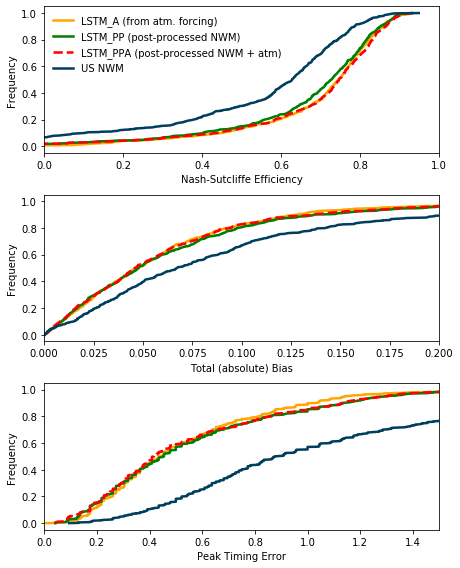

In [185]:
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.2],[-50,50], [],[],[],[0,1.5]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)

colorz=['#ffa600', 'green', 'red', '#003f5c']

linestylz=['-','-','--','-']
markz=['x','o','o','o']
linewidz = [5,2.5,2.5,2.5]
labelz=['LSTM_A (from atm. forcing)', 
        'LSTM_PP (post-processed NWM)', 
        'LSTM_PPA (post-processed NWM + atm)', 
        'US NWM']

mpl.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(3, figsize=(6.5,8))

plot_mods = ['LSTM_A', 'LSTM_PP', 'LSTM_PPA', 'NWM']
for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary[i_plot_mods][:,nmet]) for i_plot_mods in plot_mods]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], 
                        label=labelz[imod],
                        color=colorz[imod], 
                        linestyle=linestylz[imod],
                        linewidth=2.5,
                        markevery=20,
                        markersize=15)
        axes[imet].plot
        axes[imet].grid(False)
        axes[imet].set_xlim(list(met_lims[nmet]))
#        axes[imet].set_title(use_metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        axes[imet].set_xlabel(use_metric_names[imet], fontsize=10)
        
# axes.spines["top"].set_visible(False)
# axes.spines["right"].set_visible(False)
axes[0].legend(loc='upper left', fontsize=10, frameon=False)
#axes.tick_params(axis="both", which="major", labelsize=16)
#ax.set_ylabel('cumulative density', fontsize=22, labelpad=20)
fig.tight_layout() 
fig.savefig('fig3.png', dpi=1200)

In [23]:
use_metrics

['NSE', 'Beta-NSE', 'Peak-Timing']

# Plot the change in performance on a map

In [24]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [25]:
# spatial plot of improvements
bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
display_colors_from_control = {'NWM':'PRGn', 'LSTM_A':'PRGn'} #Alternative color scheme: 'PuOr'
display_bounds_from_control = {'NWM':[(0,1), (0,0.2), (0,2)], 'LSTM_A':[(0,1), (0,0.2), (0,2)]}

In [26]:
def PERFORMANCE_IMPROVEMENTS(control, test, percent=False):
    improvement={}
    percent_improvement={}
    for c, t in zip(control,test):
        improvement[t] = np.full([len(basin_list),len(use_metrics)], np.nan)
        percent_improvement[t] = np.full([len(basin_list),len(use_metrics)], np.nan)
        for m, metric in enumerate(use_metrics):
            imet=use_metric_locs[m]
            if optimal[m] == 1:
                improvement[t][:,m] = ensemble_metric_dictionary[t][:,imet] - \
                                   ensemble_metric_dictionary[c][:,imet]
                percent_improvement[t][:,m] = improvement[t][:,m] / \
                                              np.abs(ensemble_metric_dictionary[c][:,imet])
            elif optimal[m] == 0:
                improvement[t][:,m] = np.abs(ensemble_metric_dictionary[c][:,imet]) - \
                                    np.abs(ensemble_metric_dictionary[t][:,imet])
                percent_improvement[t][:,m] = improvement[t][:,m] / \
                                              np.abs(ensemble_metric_dictionary[c][:,imet])
    if percent:
        return percent_improvement
    else:
        return improvement

NSE


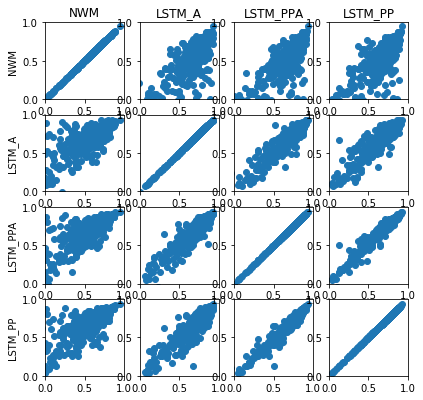

Beta-NSE


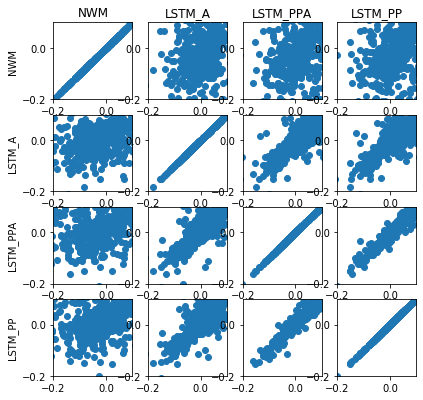

Peak-Timing


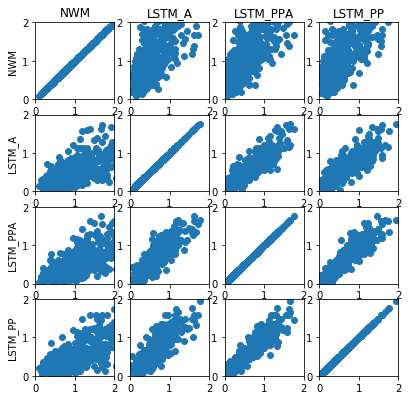

In [27]:
# Correlation grid
for imet, nmet in enumerate(use_metric_locs):
    print(use_metrics[imet])
    fig, axes = plt.subplots(len(nwm_lstm_version_list_no_cal),len(nwm_lstm_version_list_no_cal), figsize=(6.5,6.5))
    corrs = pd.DataFrame(index=nwm_lstm_version_list, columns=nwm_lstm_version_list_no_cal)
    for irow, imod in enumerate(nwm_lstm_version_list_no_cal):

        for jcol, jmod in enumerate(nwm_lstm_version_list_no_cal):

            xmod = np.array(ensemble_metric_dictionary[jmod][:,nmet])
            ymod = np.array(ensemble_metric_dictionary[imod][:,nmet])
            
            axes[irow, jcol].scatter(xmod, ymod)
            axes[irow, jcol].set_xlim(bounds[imet])
            axes[irow, jcol].set_ylim(bounds[imet])
            
    for irow, imod in enumerate(nwm_lstm_version_list_no_cal):
        axes[irow, 0].set_ylabel(imod)
    for jcol, jmod in enumerate(nwm_lstm_version_list_no_cal):
        axes[0, jcol].set_title(jmod)
                
    plt.show()
    plt.close()

In [28]:
# Correlation grid
for imet, nmet in enumerate(use_metric_locs):
    print(use_metrics[imet])
    corrs = pd.DataFrame(index=nwm_lstm_version_list, columns=nwm_lstm_version_list)
    for i, imod in enumerate(nwm_lstm_version_list):
        for j, jmod in enumerate(nwm_lstm_version_list):
            corrs.iloc[i,j] = CALCULATE_CORRELATION(imod, jmod, use_metrics=[nmet])[0]
    print(corrs)

NSE
                NWM    LSTM_A   LSTM_Ac  LSTM_PPA   LSTM_PP LSTM_PPAc  \
NWM               1  0.423323  0.649768  0.759199  0.746312  0.618681   
LSTM_A     0.423323         1  0.781899  0.770627  0.753933  0.334073   
LSTM_Ac    0.649768  0.781899         1  0.700533   0.68569  0.718773   
LSTM_PPA   0.759199  0.770627  0.700533         1  0.982095  0.401547   
LSTM_PP    0.746312  0.753933   0.68569  0.982095         1  0.391736   
LSTM_PPAc  0.618681  0.334073  0.718773  0.401547  0.391736         1   
LSTM_PPc   0.543258  0.415424  0.656974   0.48388  0.490945  0.909735   

           LSTM_PPc  
NWM        0.543258  
LSTM_A     0.415424  
LSTM_Ac    0.656974  
LSTM_PPA    0.48388  
LSTM_PP    0.490945  
LSTM_PPAc  0.909735  
LSTM_PPc          1  
Beta-NSE
                NWM    LSTM_A   LSTM_Ac  LSTM_PPA   LSTM_PP LSTM_PPAc  \
NWM               1  0.304823  0.393248  0.659781  0.652393  0.611423   
LSTM_A     0.304823         1  0.785226  0.679229  0.662531  0.402792   
LSTM_Ac

In [29]:
use_metrics

['NSE', 'Beta-NSE', 'Peak-Timing']

In [30]:
def COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=1, verbose=True):
    n_improved = {}
    for c, t in zip(control, test):
        for m, metric in enumerate(use_metrics):
            count_improved = 0
            count_detriment = 0
            count_total = 0
            imet=use_metric_locs[m]
            for i, ival in enumerate(improvement[t][:,m]):
                if ensemble_metric_dictionary['NWM'][i,0] < threshold:
                    count_total += 1
                    if ival > 0:
                        count_improved+= 1
                    if ival < 0:
                        count_detriment+= 1
            if verbose:
                print(metric)
                print('Number of improved basins = {}, {:.2f}%'.format(count_improved, 
                                                                       count_improved/count_total))
                print('Number of detrimented basins = {}, {:.2f}%'.format(count_detriment, 
                                                                          count_detriment/count_total))
            else:
                if metric == 'NSE':
                    n_improved[t] = count_improved/count_total
    return n_improved

In [31]:
def PLOT_PERFORMANCE_IMPROVEMENTS1(improvement, control, test, percent=False):
    
    bounds = display_bounds_from_control[control]
    
    fig = plt.figure(figsize=(6.5, 6.5))
    gs = fig.add_gridspec(len(use_metrics),3)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[test][:,m],
                        s=20,
                        cmap=display_colors_from_control[control],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        if m == 2:
            ax0.set_xlabel('Longitude')
        if m == 1:
            ax0.set_ylabel('Latitude')
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax1 = fig.add_subplot(gs[m,2])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
            
        for b, basin in enumerate(basin_list):
            if m==1:
                xcontrol=np.abs(ensemble_metric_dictionary[control][b,imet])
                xtest=np.abs(ensemble_metric_dictionary[test][b,imet])
            else:
                xcontrol=ensemble_metric_dictionary[control][b,imet]
                xtest=ensemble_metric_dictionary[test][b,imet]
            basin_color = im.to_rgba(improvement[test][b,m])
            ax1.scatter(xcontrol, 
                        xtest,
                        s=5,
                        color=im.to_rgba(improvement[test][b,m]))
        ax1.set_xlabel(control)
        ax1.set_ylabel(test)
        ax1.set_xlim(bounds[m])
        ax1.set_ylim(bounds[m])
        ax1.grid()

    plt.tight_layout()

In [96]:
def PLOT_PERFORMANCE_SCATTERS(improvement, control, test, percent=False):
    
    bounds = display_bounds_from_control[control[0]]
    
    fig = plt.figure(figsize=(6.5, 6.5))
    gs = fig.add_gridspec(len(use_metrics),2)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]
        
        #-------------------------------------------------------------------
        ax0 = fig.add_subplot(gs[m,0])    
        ax0.plot(bounds[m], bounds[m], 'k--', lw=0.6)
            
        # I am not sure why the color scheme has to come from this. 
        # Need to get rid of this.
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[test[0]][:,m],
                        s=20,
                        cmap=display_colors_from_control[control[0]],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
            
        for b, basin in enumerate(basin_list):
            if m==1:
                xcontrol=np.abs(ensemble_metric_dictionary[control[0]][b,imet])
                xtest=np.abs(ensemble_metric_dictionary[test[0]][b,imet])
            else:
                xcontrol=ensemble_metric_dictionary[control[0]][b,imet]
                xtest=ensemble_metric_dictionary[test[0]][b,imet]
            basin_color = im.to_rgba(improvement[test[0]][b,m])
            ax0.scatter(xcontrol, 
                        xtest,
                        s=5,
                        color=im.to_rgba(improvement[test[0]][b,m]))
        ax0.set_xlabel(control[0])
        ax0.set_ylabel(test[0])
        ax0.set_xlim(bounds[m])
        ax0.set_ylim(bounds[m])
        ax0.grid()
        ax0.set_title(metric, fontsize=10)
        #-------------------------------------------------------------------
        ax1 = fig.add_subplot(gs[m,1])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
            
        for b, basin in enumerate(basin_list):
            if m==1:
                xcontrol=np.abs(ensemble_metric_dictionary[control[1]][b,imet])
                xtest=np.abs(ensemble_metric_dictionary[test[1]][b,imet])
            else:
                xcontrol=ensemble_metric_dictionary[control[1]][b,imet]
                xtest=ensemble_metric_dictionary[test[1]][b,imet]
            basin_color = im.to_rgba(improvement[test[1]][b,m])
            ax1.scatter(xcontrol, 
                        xtest,
                        s=5,
                        color=im.to_rgba(improvement[test[1]][b,m]))
        ax1.set_xlabel(control[1])
        ax1.set_ylabel(test[1])
        ax1.set_xlim(bounds[m])
        ax1.set_ylim(bounds[m])
        ax1.grid()
        ax1.set_title(metric, fontsize=10)
        # colorbar
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
    plt.tight_layout()
    fig.savefig('fig4.png', dpi=1200)

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


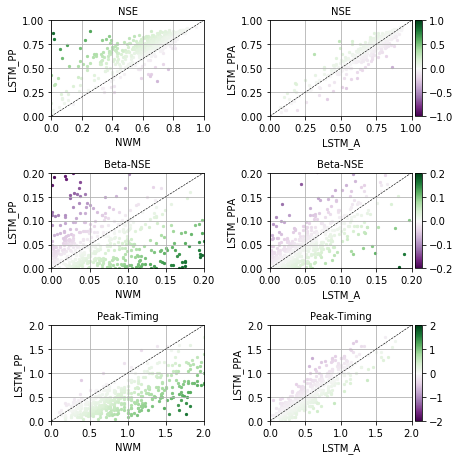

In [97]:
controls=['NWM', 'LSTM_A']
test=['LSTM_PP', 'LSTM_PPA']
improvement = PERFORMANCE_IMPROVEMENTS(controls, test, percent=False)
PLOT_PERFORMANCE_SCATTERS(improvement, controls, test)

In [98]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)
        break
        
def PLOT_PERFORMANCE_IMPROVEMENTS2(improvement, control, test, tiltez, percent=False):
    
    bound = display_bounds_from_control[control[0]]
    
    fig = plt.figure(figsize=(6.5, 6.5))
    gs = fig.add_gridspec(len(use_metrics),4)
    
    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]
        
# --------------------   TEST 1   ---------------------------------- #

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[test[0]][:,m],
                        s=20,
                        cmap=display_colors_from_control[control[0]],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        if m == 2:
            ax0.set_xlabel('Longitude')
        else:
            ax0.xaxis.set_visible(False)
        if m == 1:
            ax0.set_ylabel('Latitude')
        
        clims = im.get_clim()

        # colorbar
#        divider = make_axes_locatable(ax0)
#        cax = divider.append_axes('right', size='5%', pad=0.05)
#        fig.colorbar(im, cax=cax, orientation='vertical')
        
 # --------------------   TEST 2   ---------------------------------- #       

        ax0 = fig.add_subplot(gs[m,2:])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[test[1]][:,m],
                        s=20,
                        cmap=display_colors_from_control[control[1]],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        if m == 2:
            ax0.set_xlabel('Longitude')
        else:
            ax0.xaxis.set_visible(False)
        if m == 1:
            ax0.set_ylabel('Latitude')
        ax0.yaxis.set_visible(False)
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

#    plt.suptitle("Performance metric difference:\n"+"{}    \t   {}".format(tiltez[0],tiltez[1]), fontsize=12)    
    plt.suptitle(tiltez[0]+"  " + "   " +"  "+"  "+"  "+"  "+"  "+"  "+tiltez[1]+"\n", fontsize=12)
    format_axes(fig)
    plt.tight_layout()
    fig.savefig('fig5.png', dpi=1200)

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


NSE
Number of improved basins = 465, 0.88%
Number of detrimented basins = 66, 0.12%
Beta-NSE
Number of improved basins = 325, 0.61%
Number of detrimented basins = 206, 0.39%
Peak-Timing
Number of improved basins = 488, 0.92%
Number of detrimented basins = 32, 0.06%
NSE
Number of improved basins = 287, 0.54%
Number of detrimented basins = 244, 0.46%
Beta-NSE
Number of improved basins = 274, 0.52%
Number of detrimented basins = 257, 0.48%
Peak-Timing
Number of improved basins = 236, 0.44%
Number of detrimented basins = 222, 0.42%


{}

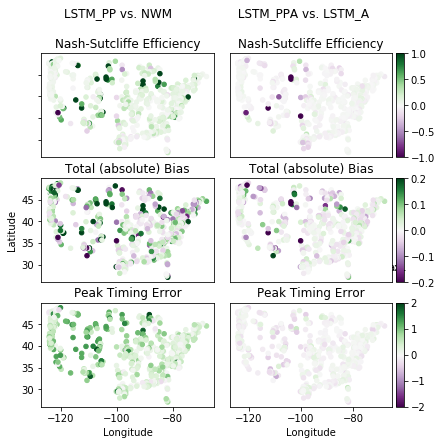

In [99]:
controls=['NWM', 'LSTM_A']
test=['LSTM_PP', 'LSTM_PPA']
tiltez = ['LSTM_PP vs. NWM', 'LSTM_PPA vs. LSTM_A']
improvement = PERFORMANCE_IMPROVEMENTS(controls, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS2(improvement, controls, test, tiltez)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, controls, test, verbose=True)

# Performance metrics for the NWM and the LSTM, LSTM Post Processor

In [36]:
# Get the days of the record that correspond to each flow type, for each basin.

if calculate_flow_categories:
    flow_dates = {fc:{b:[] for b in basin_list} for fc in flow_categories}

    for ib, b in enumerate(basin_list):  
        df = lstm_sample[b]

        for i_date, today in enumerate(date_range):
            # For a baseline also evaluate the whole record
            flow_dates['all'][b].append(today)

            # Rising and falling limbs
            if i_date>0:
                yesterday =  date_range[i_date-1]
                diff_1d = df.loc[today,'qobs']-df.loc[yesterday,'qobs']
                if diff_1d < 0:
                    flow_dates['fall'][b].append(today)
                if diff_1d > 0:
                    flow_dates['rise'][b].append(today)

            # Above or below Median
            if df.loc[today,'qobs'] > np.median(df.loc[:,'qobs']):
                flow_dates['above_mid'][b].append(today)
            else:
                flow_dates['below_mid'][b].append(today)

            # Above or below Mean
            if df.loc[today,'qobs'] > np.mean(df.loc[:,'qobs']):
                flow_dates['above_mean'][b].append(today)
            else:
                flow_dates['below_mean'][b].append(today)

            # Above or below 20th/80th percentile
            if df.loc[today,'qobs'] > np.percentile(df.loc[:,'qobs'], 80):
                flow_dates['above_80'][b].append(today)
            elif df.loc[today,'qobs'] < np.percentile(df.loc[:,'qobs'], 20):
                flow_dates['below_20'][b].append(today) 
        # Save values to pickle file
        with open(data_dir+'flow_category_dates.p','wb') as f:
            pkl.dump(flow_dates, f)
else:
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [37]:
def calc_nse(obs, sim):
    diff1 = obs - sim
    diff2 = obs - np.mean(obs)
    numer = np.nanmean(np.power(diff1,2))
    denom = np.nanmean(np.power(diff2,2))
    return 1-numer/denom
def calc_bias(obs, sim):
    sum_obs = np.sum(obs)
    sum_sim = np.sum(sim)
    return sum_obs - sum_sim
def calc_beta_nse(obs, sim):
    return float((sim.mean() - obs.mean()) / obs.std())
def calc_alpha_nse(obs, sim):
    return float(sim.std() / obs.std())

In [38]:
def constrain_flowset(flow_set, date_range):
    # make sure the flow set stays within the bounds for the testing period
    flow_set_test=[]
    for f in flow_set:
        if f <= date_range[-1]:
            flow_set_test.append(f)
    flow_set = flow_set_test
    return flow_set

In [39]:
# Get all the metrics available in one list.

if calculate_metric_matrix:

    met_mat = {fc:np.full([nbasins,n_models,nmets],np.nan) for fc in flow_categories}

    flow_mat = {fc:{mt:[] for mt in obs_nwm_lstm_version_list} for fc in flow_categories}

    did_not_calculate = []

    # Loop through the basins and calculate the performance metric.
    for ib, b in enumerate(basin_list):  
        # Keep a record of any infinities that come out of performance metric calculations.
        basin_inf = {fc:[] for fc in nwm_lstm_version_list}

        # Loop through the flow categories, and calculate the performance metrics.
        # Any flow category that is split up by percentile 
        for fc in flow_categories:
            # But some of the metrics do not make sense when the flow is split up by category
            #             i.e., the timing metrics don't make sense without consecutive days.
            if fc != flow_categories[0]:
                loop_mets = mets[0:7]
            else:
                loop_mets = mets

            flow_set = flow_dates[fc][b]
            flow_set = constrain_flowset(flow_set, date_range)

            xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
            flow_mat[fc]['obs'].extend(list(lstm_sample[b].loc[flow_set,'qobs']))

            # Do not calculate the metrics on the basins that have a mean close to zero.
            # This will lead to -inf or very low (-100xxx) Nash-Sutcliffe values.
            if np.mean(lstm_sample[b].loc[flow_set, 'qobs']) > 0:
                is_calc_metrics = True
            else:
                is_calc_metrics = False
                did_not_calculate.append([b,fc])

            # 1) combined flows from all basins into one dictionary, for overall metrics
            # 2) Calculate the metrics for each model type.
            for imt, model_type in enumerate(nwm_lstm_version_list):
                # Combine all the basins so the metrics can be calculated across them all at once.
                flow_mat[fc][model_type].extend(list(ensemble_q_dictionary[model_type][b].loc[flow_set]))
                # Now just put the curent basin's flow into an xarray to get the metrics for this basin alone.
                xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
                if is_calc_metrics:
                    met_dict = metrics.calculate_metrics(xobs, xsim, loop_mets)
                    for imet, met_name in enumerate(loop_mets):
                        if np.isinf(met_dict[met_name]):
                                basin_inf[model_type].append([b, met_name])
                        met_mat[fc][ib,imt,imet] = met_dict[met_name]
                        
    with open(data_dir+'metrics_matrix_v2_pp.p','wb') as f:
            pkl.dump(met_mat, f)
    with open(data_dir+'flow_regime_matrix_pp.p','wb') as f:
            pkl.dump(flow_mat, f)
else:
    with open(data_dir+'metrics_matrix_v2_pp.p','rb') as f:
        met_mat = pkl.load(f)
    with open(data_dir+'flow_regime_matrix_pp.p','rb') as f:
        flow_mat = pkl.load(f)

In [40]:
combined_metric_results={fr:pd.DataFrame(index=nwm_lstm_version_list, columns=combined_metric_list) 
                         for fr in flow_categories_slim}
for fc in flow_categories_slim:
    for imodel, model_name in enumerate(nwm_lstm_version_list):
        obs = np.array(flow_mat[fc]['obs'])
        sim = np.array(flow_mat[fc][model_name])
        combined_metric_results[fc].loc[model_name,'nse']=calc_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'bias']=calc_beta_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'variance']=calc_alpha_nse(obs,sim)
        combined_metric_results[fc].loc[model_name,'pearsonr'], _ = st.pearsonr(obs,sim)
combined_metric_results

{'all':                 nse        bias  variance  pearsonr
 NWM        0.753553  -0.0216604  0.835997  0.868971
 LSTM_A     0.818424  0.00657006  0.879338  0.905058
 LSTM_Ac    0.805374  0.00920526  0.874022  0.897788
 LSTM_PPA   0.825014   0.0125018  0.914792  0.908411
 LSTM_PP    0.813096   0.0146627  0.907282  0.901854
 LSTM_PPAc  0.810553 -0.00498365  0.870157  0.900843
 LSTM_PPc   0.794328 -0.00828095  0.847434  0.892424,
 'rise':                 nse        bias  variance  pearsonr
 NWM        0.727405  -0.0578381  0.808376  0.856175
 LSTM_A     0.781591  -0.0129878  0.834239  0.885666
 LSTM_Ac    0.768014  -0.0141319  0.824127  0.878141
 LSTM_PPA   0.791854 -0.00364662  0.881688  0.889907
 LSTM_PP    0.777861 -0.00694467  0.866038  0.882138
 LSTM_PPAc  0.777158  -0.0226922  0.838275  0.882991
 LSTM_PPc   0.758043  -0.0304761  0.808776  0.873598,
 'fall':                 nse         bias  variance  pearsonr
 NWM        0.782779  0.000529983   0.88528  0.884748
 LSTM_A     0.87172

In [41]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
locz = [0,1,3,4]
namz = ['NWM','LSTM_A','LSTM_PPA', 'LSTM_PP']
for fc in flow_categories_slim:
    print(fc)
    G = [np.nanmean(met_mat[fc][:,ilx,0]) for ilx in locz]
    H = [np.nanmedian(met_mat[fc][:,ilx,0]) for ilx in locz]
    I = [np.nanmedian(met_mat[fc][:,ilx,3]) for ilx in locz]
    J = [np.nanmedian(met_mat[fc][:,ilx,4]) for ilx in locz]
    K = [np.nanmedian(met_mat[fc][:,ilx,6]) for ilx in locz]
    L = [np.nanmedian(met_mat[fc][:,ilx,5]) for ilx in locz]
    M = [np.nanmedian(met_mat[fc][:,ilx,11]) for ilx in locz]
    df = pd.DataFrame(data=np.array([G, H, I, J, K, L, M]).reshape(7,len(locz)).transpose(),
                      index=namz,  
            columns=['NSE(mean)','NSE(median)','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
    print(df)
    
def calc_wilcoxon(fc, column, set_test_model, set_control_model):
    stat0, p0 = st.wilcoxon(met_mat[fc][:,set_control_model,column], met_mat[fc][:,set_test_model,column])
    return [p0]

for set_test_model, set_control_model in zip([4,3], [0,1]):
    pd.options.display.float_format = '{:.5f}'.format
    pd.set_option('expand_frame_repr', False)
    for fc in flow_categories_slim:
        print(fc)
        H = calc_wilcoxon(fc, 0, set_test_model, set_control_model)   
        I = calc_wilcoxon(fc, 3, set_test_model, set_control_model)
        J = calc_wilcoxon(fc, 4, set_test_model, set_control_model)
        K = calc_wilcoxon(fc, 6, set_test_model, set_control_model)
        L = calc_wilcoxon(fc, 5, set_test_model, set_control_model)
        M = calc_wilcoxon(fc, 11, set_test_model, set_control_model)
        df = pd.DataFrame(data=np.array([H, I, J, K, L, M]).reshape(6,1).transpose(),
                          index=['NWM'],  
                columns=['NSE','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
        print(nwm_lstm_version_list[set_test_model]+" agains "+nwm_lstm_version_list[set_control_model])
        print(df)

all
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.46142      0.62719 0.63965    0.81163  -0.01541   0.81899     0.87500
LSTM_A      0.68778      0.74454 0.73622    0.82477   0.01446   0.87757     0.43478
LSTM_PPA    0.67018      0.74619 0.75516    0.86105   0.01628   0.88085     0.41667
LSTM_PP     0.65243      0.72689 0.73733    0.84493   0.02177   0.87037     0.45455
rise
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.47615      0.59721 0.59132    0.75762  -0.07465   0.81517         nan
LSTM_A      0.66220      0.71540 0.71016    0.79443  -0.01294   0.86403         nan
LSTM_PPA    0.64884      0.71904 0.72629    0.83869  -0.00485   0.86895         nan
LSTM_PP     0.63451      0.69502 0.71227    0.81161  -0.00605   0.86154         nan
fall
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.28569      0.61545 0.63546    0.94390   0.02989 

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


# Calculate the hydrologic signatures for all the models and oberservation

In [42]:
# Calculate the hydrologic signatures for all the models, and see which is closer to the observation.
sigs = signatures.get_available_signatures()
nsigs = len(sigs)
sigs_dict = {imod:pd.DataFrame(index=basin_list, data=np.full([nbasins,nsigs],np.nan), columns=sigs) \
             for imod in obs_nwm_lstm_version_list}

for root, subdirs, files in os.walk(nldas_dir):
    for file in files:
        file_path = os.path.join(root, file)
        b = file[0:8]
        if b not in flow_dates['all'].keys():
            continue
        flow_set = flow_dates['all'][b]
        flow_set = constrain_flowset(flow_set, date_range)
        hu = attributes.loc[int(b), 'basin_hydro_unit']
        with open(file_path, 'r') as f:
            df = pd.read_csv(f, sep="\s+",header=3)
        dti = pd.date_range('1980-01-01', periods=df.shape[0], freq='D')
        df['date'] = dti
        df = df.set_index('date')
        prcp=xr.DataArray(df['PRCP(mm/day)'])

        for imt, model_type in enumerate(['NWM','LSTM_A','LSTM_PPA', 'LSTM_PP']):
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            sigs_dict[model_type].loc[b,:] = signatures.calculate_all_signatures(da=xsim, prcp=prcp)
            
        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        sigs_dict['obs'].loc[b,:] = signatures.calculate_all_signatures(da=xobs, prcp=prcp)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


high_q_freq


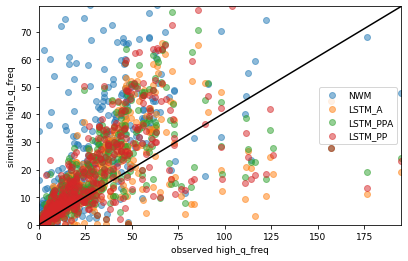

high_q_dur


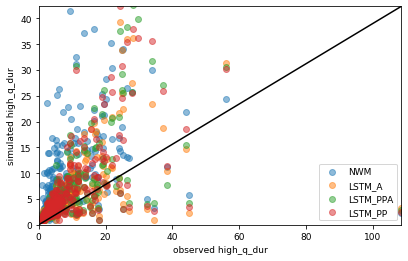

low_q_freq


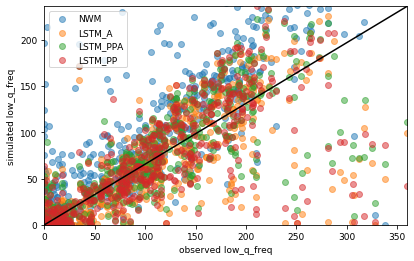

low_q_dur


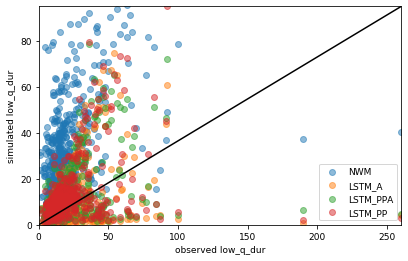

zero_q_freq


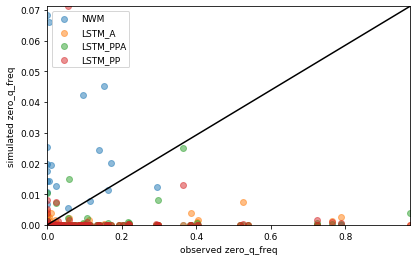

q95


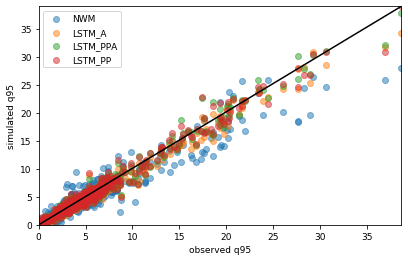

q5


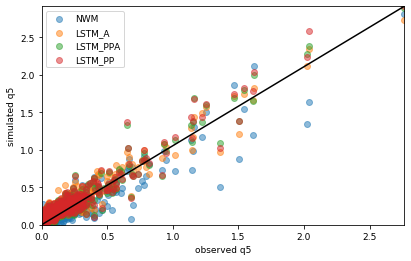

q_mean


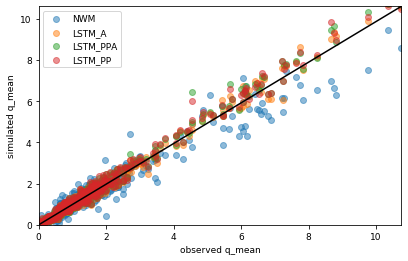

hfd_mean


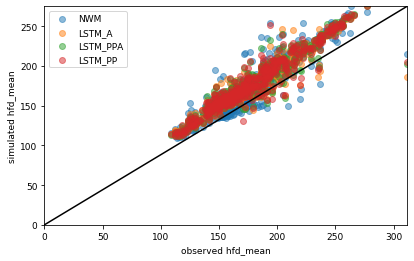

baseflow_index


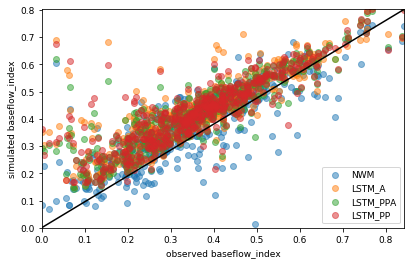

slope_fdc


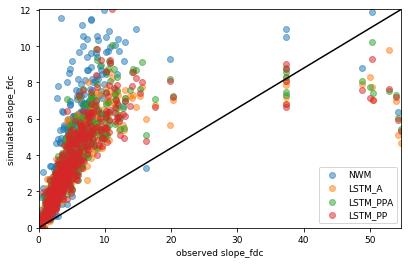

stream_elas


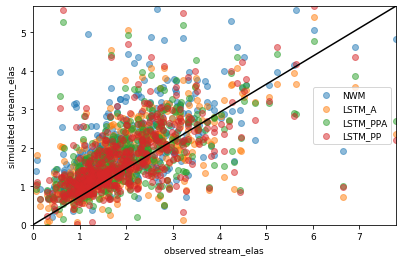

runoff_ratio


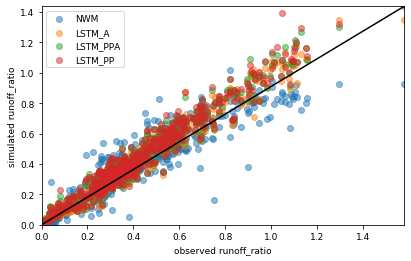

In [43]:
#RMSE Values
model_types = ['NWM','LSTM_A','LSTM_PPA', 'LSTM_PP']

df_sigs={'rmse':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types),
         'r-squared':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types)}

df_sigs_signif = pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=['LSTM_A','LSTM_PPA','LSTM_PP','n'])

for sig in sigs_dict['obs'].columns.values:
    print(sig)
    if sig=="zero_q_freq":
        df_temp = sigs_dict['obs'].loc[:,sig]
        count_zero_q_freq["obs"] = df_temp[df_temp > 0].count() 
        
    for imod in model_types:
        df_sigs['rmse'].loc[sig,imod] = np.log(np.sqrt(np.square(np.mean(sigs_dict['obs'].loc[:,sig] - 
                                         sigs_dict[imod].loc[:,sig]))))
        if sig=="zero_q_freq":
            df_temp = sigs_dict[imod].loc[:,sig]
            count_zero_q_freq[imod] = df_temp[df_temp > 0].count() 
            

    mpl.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    
    for imod in model_types:
        obs_1d = np.array(sigs_dict['obs'].loc[:,sig]).reshape(sigs_dict['obs'].loc[:,sig].shape[0],)
        sigs_1d = np.array(sigs_dict[imod].loc[:,sig]).reshape(sigs_dict[imod].loc[:,sig].shape[0],)
        df = pd.DataFrame({'obs':obs_1d, 'sig':sigs_1d})
        df = df.dropna()
        slope, intercept, r_value, p_value, std_err = st.linregress(df['obs'], df['sig'])

        df_sigs['r-squared'].loc[sig,imod] = r_value**2
        
        #Calculates the statistic significance between two dependent correlation coefficients
        if imod == 'LSTM_SF':
            df_nanfree = pd.DataFrame({'obs':sigs_dict['obs'].loc[:,sig],
                                       'NWM':sigs_dict['NWM'].loc[:,sig],
                                       'LSTM_A':sigs_dict['LSTM_A'].loc[:,sig],
                                       'LSTM_PPA':sigs_dict['LSTM_PPA'].loc[:,sig],
                                       'LSTM_PP':sigs_dict['LSTM_PP'].loc[:,sig]})
            df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
            df_nanfree = df_nanfree.dropna()

            xy = st.pearsonr(df_nanfree['NWM'], df_nanfree['obs'])[0]

            xz = st.pearsonr(df_nanfree['LSTM_PP'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_PP'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_PP'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])

            xz = st.pearsonr(df_nanfree['LSTM_PPA'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_PPA'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_PPA'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
            
            xz = st.pearsonr(df_nanfree['LSTM_A'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['NWM'], df_nanfree['LSTM_A'])[0]
            _, df_sigs_signif.loc[sig,'LSTM_A'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
            
            df_sigs_signif.loc[sig,'n'] = df_nanfree.shape[0]
        
        ax.scatter(sigs_dict['obs'].loc[:,sig], sigs_dict[imod].loc[:,sig], alpha=.5, label=imod)
        plt.grid()
    
    plt.ylabel('simulated '+sig,fontname="Arial")
    plt.xlabel('observed '+sig,fontname="Arial")
    plt.plot([0,np.max(sigs_dict['obs'].loc[:,sig])],
             [0,np.max(sigs_dict[imod].loc[:,sig])], c='k')
    plt.xlim([0,np.max(sigs_dict['obs'].loc[:,sig])])
    plt.ylim([0,np.max(sigs_dict[imod].loc[:,sig])])
    plt.legend()
    plt.show()
    plt.close()

In [44]:
count_zero_q_freq

{'obs': 97,
 'NWM': 55,
 'LSTM_A': 34,
 'LSTM_Ac': 0,
 'LSTM_PPA': 29,
 'LSTM_PP': 24,
 'LSTM_PPAc': 0,
 'LSTM_PPc': 0}

In [45]:
df_sigs_signif

LSTM_A LSTM_PPA LSTM_PP    n
high_q_freq       NaN      NaN     NaN  NaN
high_q_dur        NaN      NaN     NaN  NaN
low_q_freq        NaN      NaN     NaN  NaN
low_q_dur         NaN      NaN     NaN  NaN
zero_q_freq       NaN      NaN     NaN  NaN
q95               NaN      NaN     NaN  NaN
q5                NaN      NaN     NaN  NaN
q_mean            NaN      NaN     NaN  NaN
hfd_mean          NaN      NaN     NaN  NaN
baseflow_index    NaN      NaN     NaN  NaN
slope_fdc         NaN      NaN     NaN  NaN
stream_elas       NaN      NaN     NaN  NaN
runoff_ratio      NaN      NaN     NaN  NaN

In [46]:
sig='zero_q_freq'
df_nanfree = pd.DataFrame({'NWM':sigs_dict['NWM'].loc[:,sig],
                           'LSTM_PPA':sigs_dict['LSTM_PPA'].loc[:,sig],
                           'LSTM_A':sigs_dict['LSTM_A'].loc[:,sig],
                           'LSTM_PP':sigs_dict['LSTM_PP'].loc[:,sig]})
df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
df_nanfree = df_nanfree.dropna()
count_above_zero = {'NWM':0, 'LSTM_A':0, 'LSTM_PPA':0, 'LSTM_PP':0}
for i in df_nanfree.iterrows():
    for mod in ['NWM', 'LSTM_A', 'LSTM_PPA', 'LSTM_PP']:
        if i[1][mod] > 0:
            count_above_zero[mod] += 1
count_above_zero

{'NWM': 55, 'LSTM_A': 34, 'LSTM_PPA': 29, 'LSTM_PP': 24}

In [47]:
df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM_A','LSTM_PPA','LSTM_PP']]

NWM  LSTM_A LSTM_PPA LSTM_PP
low_q_dur      0.13680 0.07717  0.11998 0.10959
zero_q_freq    0.21904 0.09599  0.04559 0.00285
high_q_dur     0.23884 0.37652  0.37397 0.38287
stream_elas    0.36242 0.42621  0.36366 0.36920
slope_fdc      0.47777 0.42889  0.42515 0.41404
high_q_freq    0.49124 0.44086  0.48481 0.45175
low_q_freq     0.59896 0.53696  0.61093 0.52522
baseflow_index 0.71359 0.71003  0.77920 0.72628
runoff_ratio   0.82245 0.95287  0.95002 0.94986
hfd_mean       0.84566 0.90628  0.91296 0.90040
q5             0.87166 0.93111  0.93373 0.92996
q95            0.91394 0.98046  0.97908 0.97747
q_mean         0.94469 0.98804  0.98739 0.98789

In [48]:
for row in df_sigs['r-squared'].sort_values('NWM').loc[:, 
                        ['NWM', 'LSTM_A','LSTM_PPA','LSTM_PP']].iterrows():
    LSTM_A_improvement = (row[1]['LSTM_A'] - row[1]['NWM'])/row[1]['NWM']
    LSTM_PPA_improvement = (row[1]['LSTM_PPA'] - row[1]['NWM'])/row[1]['NWM']
    LSTM_PP_improvement = (row[1]['LSTM_PP'] - row[1]['NWM'])/row[1]['NWM']
    
    print('{}: {:.0%}, {:.0%}, {:.0%}'.format(row[0], 
                                                      LSTM_A_improvement, 
                                                      LSTM_PPA_improvement, 
                                                      LSTM_PP_improvement))

low_q_dur: -44%, -12%, -20%
zero_q_freq: -56%, -79%, -99%
high_q_dur: 58%, 57%, 60%
stream_elas: 18%, 0%, 2%
slope_fdc: -10%, -11%, -13%
high_q_freq: -10%, -1%, -8%
low_q_freq: -10%, 2%, -12%
baseflow_index: -0%, 9%, 2%
runoff_ratio: 16%, 16%, 15%
hfd_mean: 7%, 8%, 6%
q5: 7%, 7%, 7%
q95: 7%, 7%, 7%
q_mean: 5%, 5%, 5%


In [49]:
df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM_A','LSTM_PPA','LSTM_PP']].mean()

NWM        0.58747
LSTM_A     0.60395
LSTM_PPA   0.61281
LSTM_PP    0.59441
dtype: float64

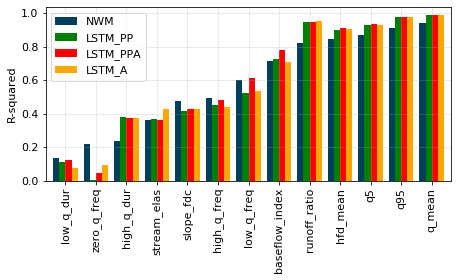

In [155]:
plot_model_names = ['NWM', 'LSTM_A','LSTM_PPA','LSTM_PP']
plot_models = ['NWM', 'LSTM_PP', 'LSTM_PPA', 'LSTM_A']
colorz={'NWM':'#ffa600', 'LSTM_PPA':'green', 'LSTM_PP':'red', 'LSTM_A':'#003f5c'}
colorz=['#003f5c', 'green', 'red','#ffa600']

fig_scale=1
mpl.rcParams.update({'font.size': 11})
#fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=False, figsize=(fig_scale*6.5, fig_scale*4.02))
fig, ax0 = plt.subplots(figsize=(fig_scale*6.5, fig_scale*4.02))

df_plot = df_sigs['r-squared'].sort_values('NWM').loc[:,plot_models]

df_plot.plot.bar(ax=ax0, width=.8, color=colorz)

ax0.set_ylabel('R-squared')
ax0.grid(alpha=0.3)
ax0.legend(plot_models)

plt.tight_layout()
plt.show()
fig.savefig('fig11.png', dpi=1200)
plt.close()

In [158]:
st.stats.pearsonr(df_plot['LSTM_PP'], df_plot['LSTM_PPA'])[0]

(0.9967777288010073, 2.0858226976081698e-13)

# POST PROCESSOR PERFORMANCE REGRESSION

In [51]:
# Python program to sort  
# one list using 
# the other list 
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [52]:
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [53]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[]):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    grid = plt.GridSpec(1, 3, wspace=0.33333)
    plt.subplot(grid[0, 0:2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 2])
    feature_importances.sort_values('total_importance', ascending=False).iloc[0:5].plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()   

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [54]:
# # Random Forest Regression in a K-fold loop
# def cross_val_lr(X,y,feature_list, kf):

#     if len(feature_list_short) > 1:
#         index_labs = feature_list_short
#     else:
#         index_labs = feature_list
    
#     rmse_list = []
#     r2_list = []
#     y_hat_list = []
#     y_hat_indx_list = []
    
# #     fig, ax = plt.subplots(figsize=(6.5,4.02))
    
#     for train_index, test_index in kf.split(X):
                
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         lr = LinearRegression()
        
#         lr.fit(X_train, y_train);
#         y_hat = lr.predict(X_test)
        
#         rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
#         slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
#         r2 = r_value**2        
#         plt.scatter(y_test,y_hat)
        
#         rmse_list.append(rmse)
#         r2_list.append(r2)
#         y_hat_list.extend(y_hat)
#         y_hat_indx_list.extend(test_index)
    
#     #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
#     plt.xlabel("target streamflow improvement")
#     plt.ylabel("predicted streamflow improvement")

#     y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
#     overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
#     slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
#     overall_r2_value = overall_r_value**2
#     print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
#     print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
#     print("RMSE Value stats for cross validation")
#     print_stats(rmse_list)
#     print("R-squared Value stats for cross validation")
#     print_stats(r2_list)
#     x=np.linspace(np.min(y), np.max(y), num=2)
#     omax = np.max([np.max(y), np.max(y_hat_all)])
#     omin = np.min([np.min(y), np.min(y_hat_all)])

# #     plt.show()
#     plt.close()    

#     return y, y_hat_all, overall_rmse, overall_r2_value, x, slope, intercept, omax, omin

In [55]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [56]:
imet=0
for model1 in lstm_version_list:

        attributes[model1] = [np.nan]*attributes.shape[0]
        for i, b in enumerate(basin_list):
            attributes.loc[int(b), model1] = ensemble_metric_dictionary[model1][i,imet]

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.17
Overall r^2 for the out-of-sample predictions: 0.97
RMSE Value stats for cross validation
mean = 0.17,  median = 0.16, stdev = 0.05, min = 0.11, max = 0.33
R-squared Value stats for cross validation
mean = 0.76,  median = 0.79, stdev = 0.21, min = 0.35, max = 1.00


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.34
Overall r^2 for the out-of-sample predictions: 0.88
RMSE Value stats for cross validation
mean = 0.30,  median = 0.23, stdev = 0.16, min = 0.13, max = 0.71
R-squared Value stats for cross validation
mean = 0.70,  median = 0.79, stdev = 0.28, min = 0.03, max = 1.00


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Overall rmse for the out-of-sample predictions: 0.33
Overall r^2 for the out-of-sample predictions: 0.89
RMSE Value stats for cross validation
mean = 0.29,  median = 0.25, stdev = 0.16, min = 0.14, max = 0.70
R-squared Value stats for cross validation
mean = 0.63,  median = 0.74, stdev = 0.32, min = 0.04, max = 1.00


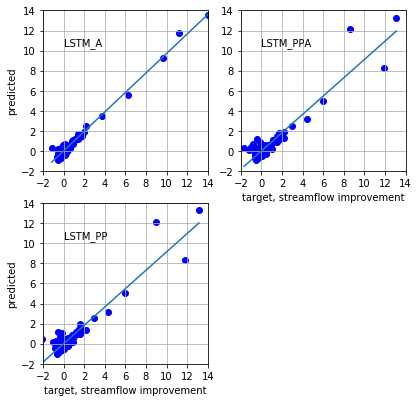

In [156]:
model2 = 'NWM'
mpl.rcParams.update({'font.size': 10})
n_splits = 20 # 528 basins / 16 splits = 33 samples in each split.
kf = KFold(n_splits=n_splits, shuffle=True)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6.5,6.5))
    
for iplot, model1 in enumerate(['LSTM_A', 'LSTM_PPA', 'LSTM_PP']):
    if iplot==0:
        iplot_row=0
        iplot_col=0
        ax[iplot_row, iplot_col].set_ylabel("predicted")
    if iplot==1:
        iplot_row=0
        iplot_col=1
        ax[iplot_row, iplot_col].set_xlabel("target, streamflow improvement")
    if iplot==2:
        iplot_row=1
        iplot_col=0
        ax[iplot_row, iplot_col].set_xlabel("target, streamflow improvement")
        ax[iplot_row, iplot_col].set_ylabel("predicted")

        
    model_diff_name = str(model1)+'-'+str(model2)
    attributes[model2] = [np.nan]*attributes.shape[0]
    attributes[model_diff_name] = [np.nan]*attributes.shape[0]
    imet=0
    r=0
    plot_change = np.full([nbasins,3],np.nan)
    for i, b in enumerate(basin_list):
        attributes.loc[int(b), model2] = ensemble_metric_dictionary[model2][i,imet]
        attributes.loc[int(b), model_diff_name] = ensemble_metric_dictionary[model1][i,imet] - \
                           ensemble_metric_dictionary[model2][i,imet]
    # Remove any rows with nan
    df = attributes.dropna()

    for i in range(df.shape[0]):
        df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

    # Make a dictionary for all the X, y values
    X = {}
    y = {}
    regressor_attributes = list(attributes.columns.values[0:44])
    regressor_attributes.append('NWM')
    target=model_diff_name
    ynormal = True
    
    X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = LinearRegression()
        
        lr.fit(X_train, y_train);
        y_hat = lr.predict(X_test)
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        ax[iplot_row, iplot_col].scatter(y_test,y_hat, c='b')
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    ax[iplot_row, iplot_col].text(0,10.5,model1)
    ax[iplot_row, iplot_col].set_xlim([-2,14])
    ax[iplot_row, iplot_col].set_ylim([-2,14])
    ax[iplot_row, iplot_col].set_xticks([-2,0,2,4,6,8,10,12,14])
    ax[iplot_row, iplot_col].plot(x, x*slope+intercept)
    ax[iplot_row, iplot_col].grid()
#     if iplot==0:
#         ax[iplot_row, iplot_col].xaxis.set_ticklabels([])
    
#    ax[iplot_row, iplot_col].legend([])
    
#    grid.tight_layout(fig)
    ax[-1, -1].axis('off')
plt.show()
fig.savefig('fig7.png', dpi=1200)
plt.close()   


In [58]:
regressor_attributes = ['geol_1st_class','glim_1st_class_frac','carbonate_rocks_frac','geol_porostiy','geol_permeability',
 'p_mean','pet_mean','p_seasonality','frac_snow','aridity','high_prec_freq','high_prec_dur','low_prec_freq',
 'low_prec_dur','low_prec_timing',
 'gauge_lat','gauge_lon','elev_mean',
 'area_gages2','area_geospa_fabric',
 'soil_depth_pelletier','soil_depth_statsgo',
 'max_water_content','sand_frac','silt_frac','clay_frac','other_frac','frac_forest',
 'lai_max','gvf_max','dom_land_cover_frac','dom_land_cover','basin_hydro_unit']

In [169]:
df

q_mean  runoff_ratio  slope_fdc  baseflow_index  stream_elas      q5      q95  high_q_freq  high_q_dur  low_q_freq  ...  LSTM_A  LSTM_Ac  LSTM_PPA  LSTM_PP  LSTM_PPAc  LSTM_PPc     NWM  LSTM_A-NWM  LSTM_PPA-NWM  LSTM_PP-NWM
gauge_id                                                                                                                      ...                                                                                                        
1022500  2.17306       0.60227    1.77628         0.55448      1.70278 0.20473  7.12305      3.90000     2.29412    65.15000  ... 0.81159  0.70691   0.73100  0.68452    0.70189   0.66267 0.65669     0.15490       0.07431      0.02783
1031500  2.03024       0.57629    1.49402         0.44509      1.64869 0.11134  8.01050     18.90000     3.28696    94.80000  ... 0.80143  0.77795   0.80284  0.77007    0.81507   0.79764 0.72944     0.07199       0.07340      0.04063
1047000  2.18287       0.65687    1.41594         0.47346      1.51024 0.19646  8.09515     14.95000     2.57759    71.55000  ... 0.83239  0.81975   0.86330  0.84601    0.86528   0.85850 0.76695     0.06544       0.09635      0.07907
1052500  2.40510       0.64465    1.30106         0.45970      1.02555 0.30596  8.66902     14.10000     2.51786    58.90000  ... 0.83546  0.84473   0.85595  0.84144    0.85821   0.84344 0.70751     0.12794       0.14843      0.13392
1054200  2.73174       0.67166    1.31965         0.43705      1.35781 0.25685 10.09561     16.05000     1.88823    82.20000  ... 0.79744  0.79208   0.80212  0.78748    0.80514   0.76111 0.81364    -0.01620      -0.01152     -0.02616
...          ...           ...        ...             ...          ...     ...      ...          ...         ...         ...  ...     ...      ...       ...      ...        ...       ...     ...         ...           ...          ...
14309500 2.45770       0.49373    1.68989         0.45946      1.22010 0.05765 10.20313     41.10000     4.83529   165.55000  ... 0.86121  0.85543   0.85478  0.84877    0.86463   0.84622 0.81955     0.04166       0.03523      0.02922
14316700 2.92594       0.64400    2.23102         0.50862      1.55248 0.14149 10.65357     16.15000     2.54331   136.40000  ... 0.84295  0.84344   0.87337  0.87640    0.86992   0.84746 0.82498     0.01797       0.04839      0.05142
14325000 4.07228       0.64666    2.24613         0.48077      1.12798 0.10492 15.89195     23.80000     3.21622   153.35000  ... 0.88516  0.87109   0.88724  0.87559    0.88911   0.87758 0.84413     0.04103       0.04311      0.03146
14362250 0.33202       0.11936    1.18604         0.51841      2.69449 0.00000  1.35855     33.55000     9.86765   148.05000  ... 0.75177  0.77039   0.83607  0.70929    0.74279   0.71799 0.62718     0.12459       0.20890      0.08212
14400000 7.56810       1.36213    2.01743         0.48578      1.38623 0.25071 31.22680     26.45000     3.52667   148.45000  ... 0.89222  0.88487   0.89926  0.88235    0.90298   0.89366 0.84306     0.04917       0.05621      0.03929

[528 rows x 57 columns]

In [173]:
for imet, nmet in enumerate([0,6,11]):
    m = metric_names[imet]
    df_plot = pd.DataFrame(data=np.transpose(np.array([huc_stat_dict[m][imod] for imod in plot_models])), 
                           index=range(1, 19), columns=plot_models)
    print(m)
    print('LSTM_PP v LSTM_PPA', st.stats.pearsonr(df['LSTM_PP-NWM'], df['LSTM_PPA-NWM'])[0])
    print('LSTM_PPA', st.stats.pearsonr(df['LSTM_A-NWM'], df['LSTM_PPA-NWM'])[0])
    print('LSTM_PP', st.stats.pearsonr(df['LSTM_A-NWM'], df['LSTM_PPA-NWM'])[0])

Nash-Sutcliffe Efficiency
LSTM_PP v LSTM_PPA 0.9953276779859989
LSTM_PPA 0.9747354673247421
LSTM_PP 0.9747354673247421
Total Bias
LSTM_PP v LSTM_PPA 0.9953276779859989
LSTM_PPA 0.9747354673247421
LSTM_PP 0.9747354673247421
Peak Timing Error
LSTM_PP v LSTM_PPA 0.9953276779859989
LSTM_PPA 0.9747354673247421
LSTM_PP 0.9747354673247421


### All NWM state and flux values

In [60]:
# load dynamic features data, which has all the NWM States and Fluxes
with open(data_dir+'dynamic_features_nwm_v2.p', 'rb') as f:
    dynamic_features_data = pkl.load(f)

In [61]:
nwm_columns = list(dynamic_features_data[sample_basin].columns[10:])

In [62]:
nwm_average_values = pd.DataFrame(index=basin_list, columns=nwm_columns)
for b, basin in enumerate(basin_list):
    nwm_average_values.loc[basin,:] = dynamic_features_data[basin].iloc[10:].mean()
nwm_average_values

streamflow q_lateral velocity qSfcLatRunoff qBucket qBtmVertRunoff   ACCET     FIRA       FSA    FSNO  ... SOIL_W1 SOIL_W2 SOIL_W3 SOIL_W4      TRAD UGDRNOFF mean_sfcheadsubrt mean_zwattablrt max_sfcheadsubrt max_zwattablrt
01022500   11.80678   0.05726  0.67408       0.00901 0.04956      178.41287 0.16003 53.78358 133.90569 0.30298  ... 0.27061 0.28866 0.30100 0.30613 280.38024  0.05956           0.00000         2.00000          0.00000        2.00000
01031500   14.91785   0.09322  0.11252       0.08603 0.01723       62.05605 0.14284 51.75442 128.54072 0.38806  ... 0.28084 0.30631 0.32543 0.34309 278.06529  0.01613           0.00000         2.00000          0.00000        2.00000
01047000   20.97725   0.09989  0.76204       0.08411 0.02694       97.03694 0.14900 51.31855 135.75556 0.42473  ... 0.23537 0.26322 0.28487 0.30819 277.45750  0.02696           0.00000         2.00000          0.00000        2.00000
01052500    9.32967   0.02324  1.15628       0.00081 0.03600      129.59121 0.14388 48.70902 128.11123 0.43817  ... 0.28386 0.30584 0.31811 0.33307 276.81217  0.05022           0.00000         2.00000          0.00000        2.00000
01054200    5.51216   0.01970  0.96970       0.01941 0.01241       44.68099 0.17124 49.85445 142.05464 0.46513  ... 0.21850 0.25635 0.28580 0.30695 276.62149  0.07554           0.00000         2.00000          0.00000        2.00000
...             ...       ...      ...           ...     ...            ...     ...      ...       ...     ...  ...     ...     ...     ...     ...       ...      ...               ...             ...              ...            ...
11482500   25.29624   0.21110  0.58753       0.01624 0.19905      716.47005 0.14034 67.85576 179.18565 0.05828  ... 0.31058 0.31471 0.32340 0.34778 283.74471  0.12721           0.00000         2.00000          0.00000        2.00000
11522500   57.19554   0.06526  1.44764       0.01183 0.05777      207.93827 0.11116 72.13259 174.51202 0.33703  ... 0.24413 0.24986 0.25487 0.26544 280.66653  0.26009           0.00000         2.00000          0.00000        2.00000
11523200   11.01348   0.07853  1.11865       0.01893 0.06367      229.19817 0.06387 77.37446 164.46590 0.44909  ... 0.17525 0.19248 0.21120 0.25821 278.51080  0.23864           0.00000         2.00000          0.00000        2.00000
11528700   42.45678   0.04810  1.02632       0.00260 0.05117      184.20374 0.16493 71.07061 177.73345 0.30486  ... 0.25251 0.26180 0.26651 0.27415 280.68853  0.13078           0.00000         2.00000          0.00000        2.00000
11532500  103.87407   0.02944  1.39749       0.01453 0.02531       91.11037 0.10754 63.29900 179.69583 0.01072  ... 0.33036 0.33231 0.33585 0.34350 282.50251  0.40909           0.00000         2.00000          0.00000        2.00000

[531 rows x 28 columns]

In [63]:
nwm_average_values_soil_M = nwm_average_values.columns[14:18]
nwm_average_values_soil_W = nwm_average_values.columns[18:22]
nwm_average_values_soil_slim = nwm_average_values.copy(deep=True)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_M, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_W, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(['mean_sfcheadsubrt',
                                'mean_zwattablrt','max_sfcheadsubrt','max_zwattablrt'], axis = 1)
nwm_average_values_soil_slim['SM_W'] = np.mean(nwm_average_values.loc[:,nwm_average_values_soil_W], axis=1)
nwm_average_values_soil_slim['SM_M'] = np.mean(nwm_average_values.loc[:,nwm_average_values_soil_M], axis=1)

nwm_average_values_soil_slim['zwattablrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_zwattablrt','max_zwattablrt')], axis=1)
nwm_average_values_soil_slim['sfcheadsubrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_sfcheadsubrt','max_sfcheadsubrt')], axis=1)
nwm_average_values_soil_slim
nwm_columns_soil_slim = nwm_average_values_soil_slim.columns.values

In [64]:
nwm_lstm_version_list

['NWM', 'LSTM_A', 'LSTM_Ac', 'LSTM_PPA', 'LSTM_PP', 'LSTM_PPAc', 'LSTM_PPc']

In [65]:
base_models

['NWM', 'LSTM_A']

In [66]:
optimal = [1, 0, 0]
test_names=['LSTM_PP', 'LSTM_PPA']
test_columns=[3,4]
improvements = {i:{} for i in test_names}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        for imet, metric in enumerate(use_metrics):
            control = met_mat[fc][:,imt,imet]       #metric_values.loc[:,(hyd, metric, 'test')]
            for test_col, test_name in zip(test_columns,test_names):
                test = met_mat[fc][:,test_col,imet]
                if optimal[imt] == 1:
                    improvements[test_name][(fc,mod,metric)] = test-control
                elif optimal[imt] == 0:
                    improvements[test_name][(fc,mod,metric)] = (np.abs(test)-np.abs(control))

In [67]:
corr = {i:{} for i in test_names}
for test_col, test_name in zip(test_columns,test_names):
    for ifc, fc in enumerate(flow_categories_very_slim):    
        for imt, mod in enumerate(base_models):
            corr[test_name][(fc,mod)] = pd.DataFrame(index=nwm_columns_soil_slim, columns=use_metrics)
            for imet, metric in enumerate(use_metrics):
                for i, inpt in enumerate(nwm_columns_soil_slim):
                    x = nwm_average_values_soil_slim[inpt].values.astype(float)
                    y = improvements[test_name][(fc,mod,metric)]
                    corr[test_name][(fc,mod)].loc[inpt,metric] = np.corrcoef(x, y)[0,1]          

In [68]:
for test_col, test_name in zip(test_columns,test_names):
    for ifc, fc in enumerate(flow_categories_very_slim):    
        for imt, mod in enumerate(base_models):
            corr[test_name][(fc,mod)].rename(columns={use_metrics[i]:short_metric_names[i] for i in range(3)})
            corr[test_name][(fc,mod)] = corr[test_name][(fc,mod)].rename(index={'qSfcLatRunoff':'qLateral', 
                                                                                'qBtmVertRunoff':'qBottom'})

In [69]:
corr

{'LSTM_PP': {('all',
   'NWM'):                   NSE Beta-NSE Peak-Timing
  streamflow   -0.09388 -0.17701    -0.07686
  q_lateral    -0.05274 -0.15742    -0.09853
  velocity      0.01259 -0.32890    -0.28272
  qLateral     -0.08500 -0.13149    -0.05689
  qBucket      -0.01005 -0.15253    -0.12439
  qBottom      -0.01010 -0.15244    -0.12425
  ACCET        -0.06981  0.25189     0.21707
  FIRA          0.11105  0.08172     0.06414
  FSA          -0.05024  0.04537     0.13595
  FSNO          0.13204 -0.11989    -0.20177
  HFX          -0.08966 -0.21067    -0.04125
  LH           -0.06810  0.25461     0.21874
  SNEQV         0.00392 -0.13255    -0.13694
  SNOWH         0.01647 -0.15709    -0.17570
  TRAD         -0.14308  0.17625     0.26597
  UGDRNOFF      0.05318 -0.47003    -0.39063
  SM_W         -0.10164 -0.06417    -0.00300
  SM_M         -0.04140 -0.05718    -0.03914
  zwattablrt   -0.07482 -0.20904    -0.16501
  sfcheadsubrt -0.01886  0.03004     0.04887,
  ('all',
   'LSTM_A'): 

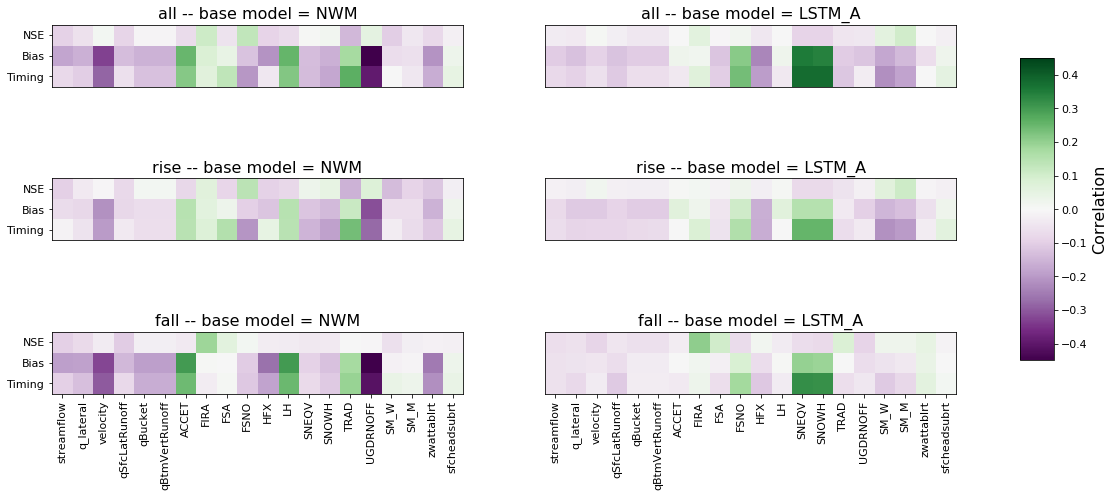

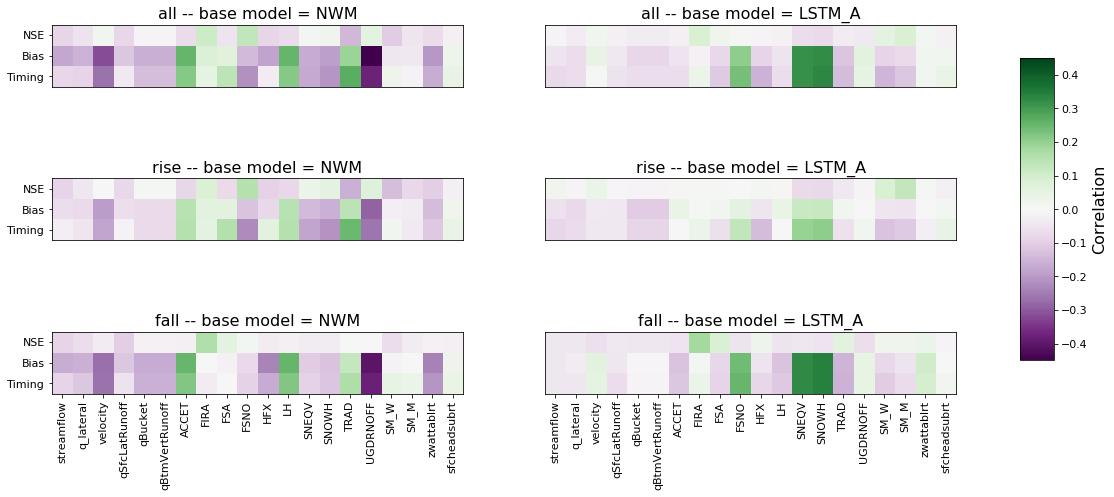

In [194]:
for test_col, test_name in zip(test_columns,test_names):
    fig, ax = plt.subplots(3,2,figsize=(16,8))
    for ifc,fc in enumerate(flow_categories_very_slim):    
        for imt, mod in enumerate(base_models):
            im = ax[ifc,imt].imshow(corr[test_name][(fc,mod)].transpose().astype(float),
                           cmap='PRGn',
                          vmax=0.45, vmin=-0.45)
            ax[ifc,imt].set_xticks([])
            ax[ifc,imt].set_yticks([])
            ax[ifc,imt].set_title(f"{fc.replace('_',' ')} -- base model = {base_models[imt]}", fontsize=16)

    ax[2,0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
    ax[2,1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
    ax[2,0].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')
    ax[2,1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

    ax[0,0].set_yticks(range(len(use_metrics)))
    ax[1,0].set_yticks(range(len(use_metrics)))
    ax[2,0].set_yticks(range(len(use_metrics)))
    ax[0,0].set_yticklabels(short_metric_names)
    ax[1,0].set_yticklabels(short_metric_names)
    ax[2,0].set_yticklabels(short_metric_names)

    fig.subplots_adjust(right=0.91)
    cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Correlation', fontsize=16)


In [71]:
for imt, (test_name, base_name) in enumerate(zip(test_names, base_models)):
    print(imt, test_name, base_name)

0 LSTM_PP NWM
1 LSTM_PPA LSTM_A


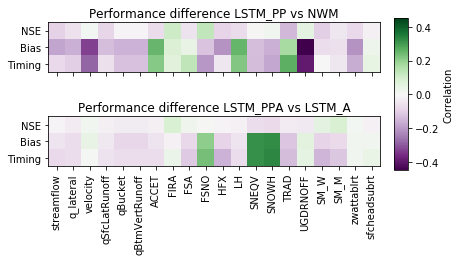

In [195]:
mpl.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(2,1,figsize=(6.5,4.02))
for imt, (test_name, base_name) in enumerate(zip(test_names, base_models)):
    im = ax[imt].imshow(corr[test_name][('all',base_name)].transpose().astype(float),
                   cmap='PRGn',
                  vmax=0.45, vmin=-0.45)
    ax[imt].set_xticks([])
    ax[imt].set_yticks([])
    ax[imt].set_title('Performance difference {} vs {}'.format(test_name, base_name))
        
ax[0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0].set_yticks(range(len(use_metrics)))
ax[1].set_yticks(range(len(use_metrics)))
ax[0].set_yticklabels(short_metric_names)
ax[1].set_yticklabels(short_metric_names)

plt.tight_layout()
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.35, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation')
fig.savefig('fig8.png', dpi=1200)

In [73]:
for imt, (test_name, base_name) in enumerate(zip(test_names, base_models)):
    print(np.abs(np.mean(corr[test_name][('all',base_name)].transpose().astype(float), axis=0)).sort_values())

sfcheadsubrt   0.02002
FSA            0.04369
SM_M           0.04590
SM_W           0.05627
FSNO           0.06321
FIRA           0.08564
SNEQV          0.08852
qLateral       0.09113
qBottom        0.09560
qBucket        0.09565
TRAD           0.09971
q_lateral      0.10290
SNOWH          0.10544
HFX            0.11386
streamflow     0.11592
ACCET          0.13305
LH             0.13508
zwattablrt     0.14963
velocity       0.19968
UGDRNOFF       0.26916
dtype: float64
sfcheadsubrt   0.01236
zwattablrt     0.01651
velocity       0.02255
UGDRNOFF       0.02576
SM_M           0.03198
qLateral       0.03624
FIRA           0.03671
LH             0.04336
ACCET          0.04355
streamflow     0.04461
q_lateral      0.05343
FSA            0.05468
qBottom        0.05913
qBucket        0.05917
SM_W           0.06113
HFX            0.08438
TRAD           0.09272
FSNO           0.14793
SNEQV          0.18987
SNOWH          0.19518
dtype: float64


# Split by if calibrated basin

                        mean  median     max       min
NWM                  0.48989 0.63504 0.94806 -10.81102
LSTM_A               0.68213 0.74173 0.93022  -0.63730
LSTM_A(C)            0.67363 0.73987 0.93043  -1.13085
LSTM_PPA             0.66464 0.74808 0.93287  -3.61251
LSTM_PPA(C)          0.66634 0.75054 0.93695  -2.70558
LSTM_PP              0.64713 0.72980 0.93121  -3.31925
LSTM_PPc             0.65379 0.73359 0.93075  -1.85660
LSTM_PPc - NWM       0.16390 0.08367 9.33253  -1.30910
LSTM_PPAc - LSTM_Ac -0.00729 0.01158 0.31124  -2.45946
                        mean   median     max       min
NWM                  0.17725  0.48478 0.78945  -7.10426
LSTM_A               0.72975  0.74509 0.88510   0.42689
LSTM_A(C)            0.50689  0.67469 0.84271  -2.54291
LSTM_PPA             0.70958  0.73123 0.88873   0.42198
LSTM_PPA(C)          0.12806  0.58022 0.83576 -14.06680
LSTM_PP              0.68972  0.70725 0.88657   0.37599
LSTM_PPc             0.20956  0.57496 0.75483  -8.12473
LS

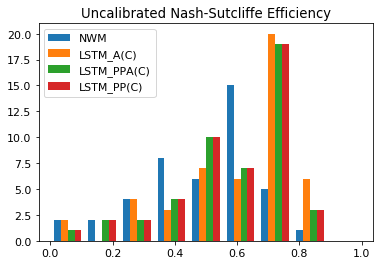

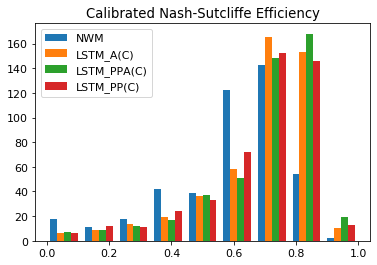

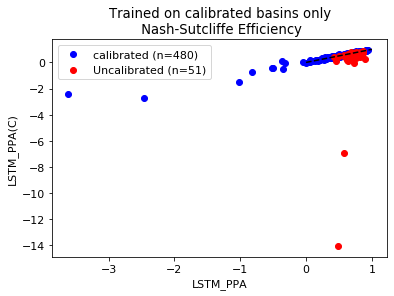

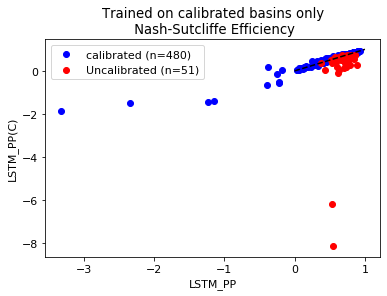

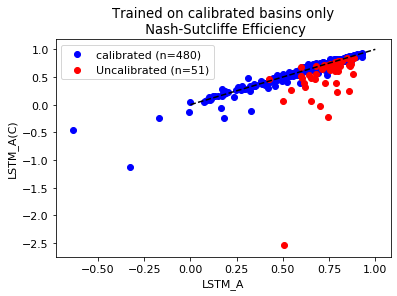

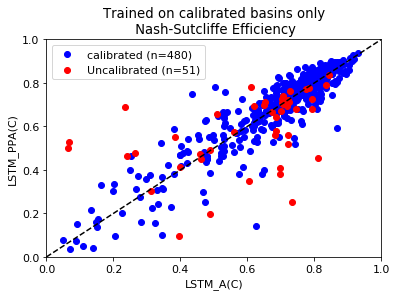

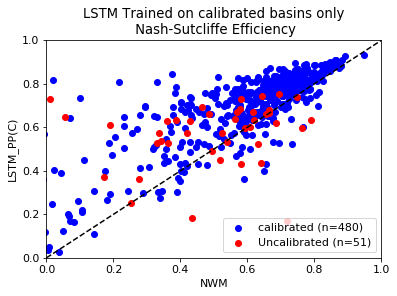

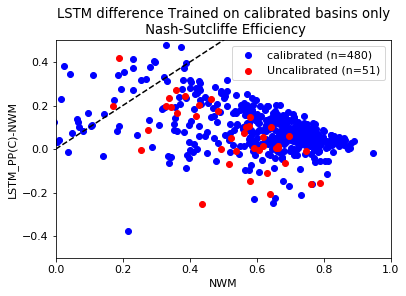

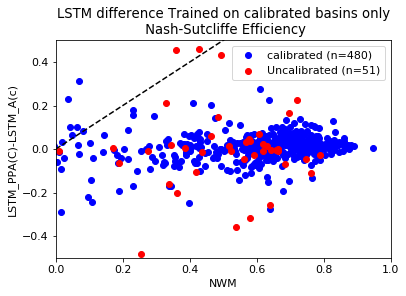

                        mean   median     max      min
NWM                  0.01241 -0.00650 2.57427 -0.62788
LSTM_A               0.01917  0.01505 0.56329 -0.22251
LSTM_A(C)            0.02220  0.01527 0.61733 -0.21408
LSTM_PPA             0.03023  0.01699 0.98183 -0.21132
LSTM_PPA(C)          0.00781 -0.00313 0.95475 -0.22241
LSTM_PP              0.03511  0.02220 1.05427 -0.24157
LSTM_PPc             0.00533 -0.00532 0.91778 -0.24753
LSTM_PPc - NWM      -0.00709  0.00462 0.47986 -1.65649
LSTM_PPAc - LSTM_Ac -0.01439 -0.01475 0.89100 -0.30637
                        mean   median     max      min
NWM                  0.00004 -0.05961 1.84046 -0.57580
LSTM_A               0.02048  0.01081 0.19672 -0.11298
LSTM_A(C)            0.08952  0.04371 0.99145 -0.20344
LSTM_PPA             0.01234  0.00140 0.21754 -0.10853
LSTM_PPA(C)          0.05900 -0.04617 2.89299 -0.41487
LSTM_PP              0.01759  0.00929 0.27243 -0.12203
LSTM_PPc             0.05785 -0.03616 2.14914 -0.50668
LSTM_PPc -

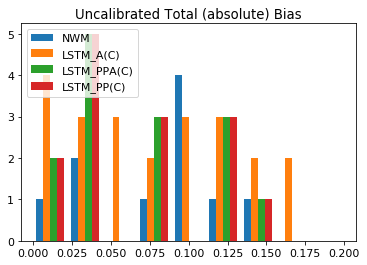

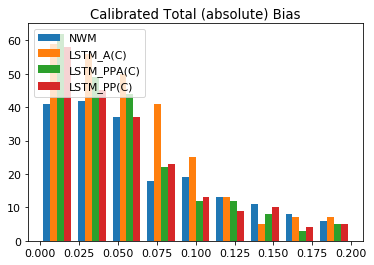

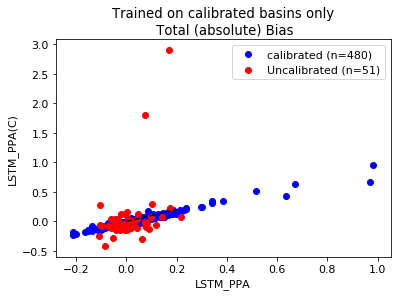

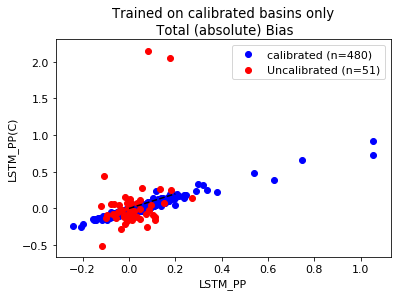

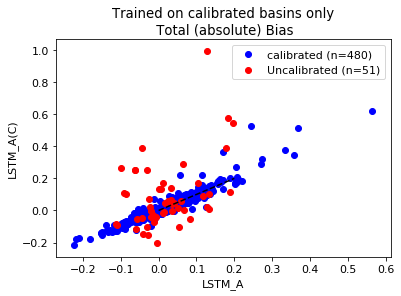

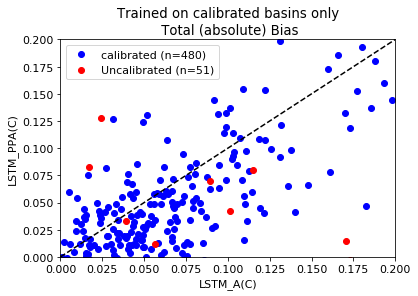

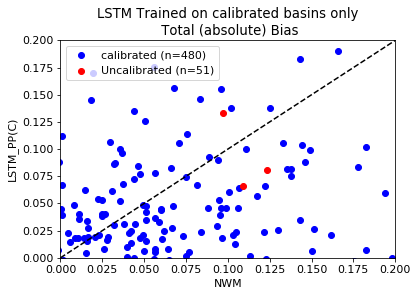

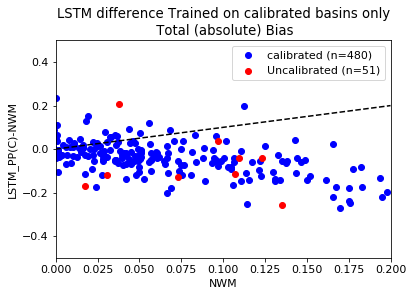

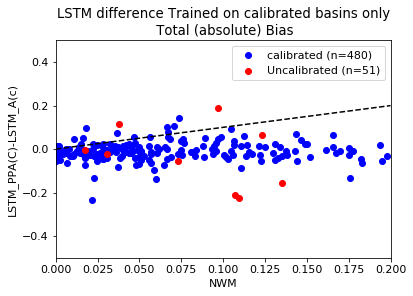

                        mean   median     max      min
NWM                  1.05856  0.90909 3.00000  0.09524
LSTM_A               0.52715  0.43478 1.76190  0.00000
LSTM_A(C)            0.52186  0.43478 1.77273  0.00000
LSTM_PPA             0.53851  0.41667 1.75000  0.04167
LSTM_PPA(C)          0.53652  0.40909 1.83333  0.04167
LSTM_PP              0.55430  0.45455 1.95238  0.04167
LSTM_PPc             0.55325  0.45455 2.09524  0.00000
LSTM_PPc - NWM      -0.50531 -0.40909 0.23810 -1.92000
LSTM_PPAc - LSTM_Ac  0.01466  0.00000 0.76000 -0.41667
                        mean   median     max      min
NWM                  1.04058  0.77273 2.69565  0.25000
LSTM_A               0.51321  0.40909 1.50000  0.04167
LSTM_A(C)            0.57208  0.50000 1.50000  0.08333
LSTM_PPA             0.51037  0.36364 1.45000  0.04545
LSTM_PPA(C)          0.57443  0.40909 1.65000  0.12500
LSTM_PP              0.51552  0.34783 1.59091  0.04348
LSTM_PPc             0.59087  0.40909 1.76190  0.09091
LSTM_PPc -

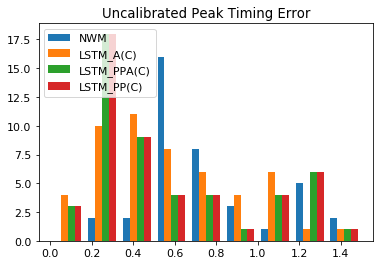

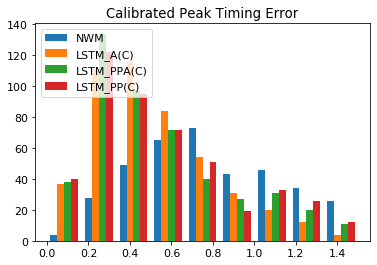

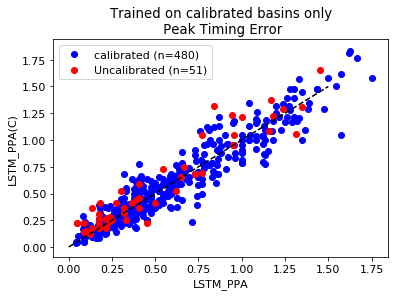

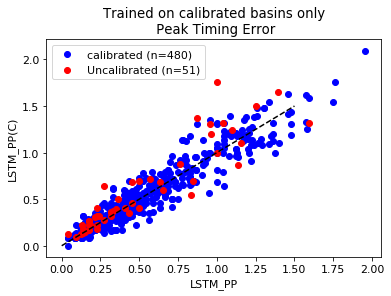

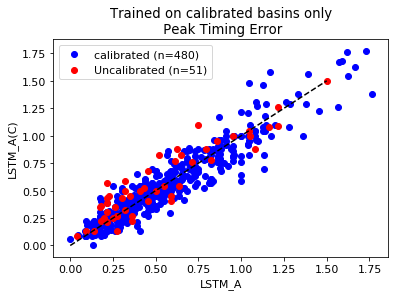

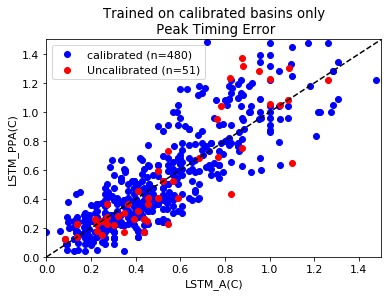

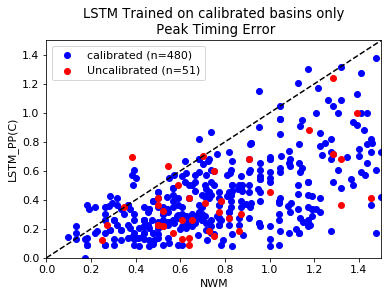

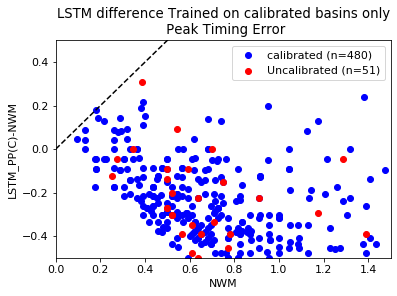

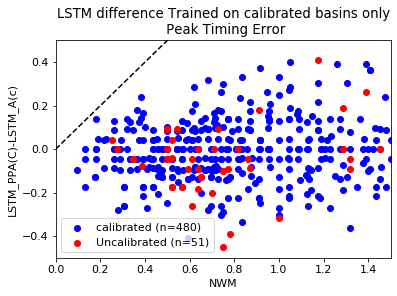

In [74]:
for imet, nmet in enumerate([0,6,11]):
    attributes2 = attributes.copy(deep=True).dropna()
    
    list_mod = ['NWM','LSTM_A','LSTM_Ac','LSTM_PPA','LSTM_PPAc', 'LSTM_PP','LSTM_PPc','diff_PPc','diff_PPAc']
    for imod in list_mod:
        attributes2[imod] = [np.nan]*attributes2.shape[0]
 
    r=0
    for i, b in enumerate(basin_list):
        for imod in list_mod[0:-2]:
            attributes2.loc[int(b), imod] = ensemble_metric_dictionary[imod][i,nmet]
        attributes2.loc[int(b), 'diff_PPc'] = \
                           ensemble_metric_dictionary['LSTM_PPc'][i,nmet] - \
                           ensemble_metric_dictionary['NWM'][i,nmet]
        attributes2.loc[int(b), 'diff_PPAc'] = \
                           ensemble_metric_dictionary['LSTM_PPAc'][i,nmet] - \
                           ensemble_metric_dictionary['LSTM_Ac'][i,nmet]
        
    # Get rid of the outlier basins, for the sake of argument
    # But make sure to include them in the full analysis
    if False:
        df = attributes2.dropna().drop([1466500, 1484100])
    else:
        df = attributes2.dropna()
        
    mod_namez = ['NWM', 'LSTM_A', 'LSTM_A(C)', 'LSTM_PPA', 'LSTM_PPA(C)', 'LSTM_PP','LSTM_PPc', 
                 'LSTM_PPc - NWM', 'LSTM_PPAc - LSTM_Ac']
    cal_df = pd.DataFrame(index=mod_namez, columns=['mean', 'median', 'max', 'min'])
    uncal_df = pd.DataFrame(index=mod_namez, columns=['mean', 'median', 'max', 'min'])    
    for model_type, model_namex in zip(list_mod, mod_namez):
        uncal_df.loc[model_namex, 'mean'] = df.groupby('calibrated')[model_type].mean()[0]
        uncal_df.loc[model_namex, 'median'] = df.groupby('calibrated')[model_type].median()[0]
        uncal_df.loc[model_namex, 'max'] = df.groupby('calibrated')[model_type].max()[0]
        uncal_df.loc[model_namex, 'min'] = df.groupby('calibrated')[model_type].min()[0]
        cal_df.loc[model_namex, 'mean'] = df.groupby('calibrated')[model_type].mean()[1]
        cal_df.loc[model_namex, 'median'] = df.groupby('calibrated')[model_type].median()[1]
        cal_df.loc[model_namex, 'max'] = df.groupby('calibrated')[model_type].max()[1]
        cal_df.loc[model_namex, 'min'] = df.groupby('calibrated')[model_type].min()[1]
    print(cal_df)
    print(uncal_df)
    
    cal_dict = {imod:[] for imod in list_mod}
    uncal_dict = {imod:[] for imod in list_mod}
    
    for ib, b in enumerate(basin_list):
        if int(b) in list(df.index.values):
            if df.loc[int(b),'calibrated']:
                for imod in list_mod:
                    cal_dict[imod].append(df.loc[int(b),imod])
            else:
                for imod in list_mod:
                    uncal_dict[imod].append(df.loc[int(b),imod])

    # Check for significance between the two samples.
    print('significance tests')
    print('cal_bas_nwm vs uncal_bas_nwm', st.mannwhitneyu(cal_dict['NWM'], uncal_dict['NWM'])[1])
    print('cal_bas_A vs uncal_bas_A', st.mannwhitneyu(cal_dict['LSTM_A'], uncal_dict['LSTM_A'])[1])
    print('cal_bas_Ac vs uncal_bas_Ac', st.mannwhitneyu(cal_dict['LSTM_Ac'], uncal_dict['LSTM_Ac'])[1])
    print('cal_bas_PPA vs uncal_bas_PPA', st.mannwhitneyu(cal_dict['LSTM_PPA'], uncal_dict['LSTM_PPA'])[1])
    print('cal_bas_PPAc vs uncal_bas_PPAc', st.mannwhitneyu(cal_dict['LSTM_PPAc'], uncal_dict['LSTM_PPAc'])[1])
    print('cal_bas_PP vs uncal_bas_PP', st.mannwhitneyu(cal_dict['LSTM_PP'], uncal_dict['LSTM_PP'])[1])
    print('cal_bas_PPc vs uncal_bas_PPc', st.mannwhitneyu(cal_dict['LSTM_PPc'], uncal_dict['LSTM_PPc'])[1])
    print('diff_PPAc_cal vs diff_PPAc_uncal', st.mannwhitneyu(cal_dict['diff_PPAc'], uncal_dict['diff_PPAc'])[1])
    print('diff_PPc_cal vs diff_PPc_uncal', st.mannwhitneyu(cal_dict['diff_PPc'], uncal_dict['diff_PPc'])[1])
    
#     for imod in ['NWM', 'LSTM_Ac', 'LSTM_PPAc', 'LSTM_PPc']:
#         for idict in [cal_dict, uncal_dict]:
#             for i, j in enumerate(idict[imod]):
#                 if j < met_lims[nmet][0]:
#                     idict[imod][i] = met_lims[nmet][0]
#                 if j > met_lims[nmet][1]:
#                     idict[imod][i] = met_lims[nmet][1]
    
    # Uncalibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([uncal_dict['NWM'],uncal_dict['LSTM_Ac'], uncal_dict['LSTM_PPAc'], uncal_dict['LSTM_PPAc']], 
             bins, label=['NWM','LSTM_A(C)', 'LSTM_PPA(C)', 'LSTM_PP(C)'])
    plt.title('Uncalibrated '+use_metric_names[imet])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()
    # Calibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([cal_dict['NWM'],cal_dict['LSTM_Ac'], cal_dict['LSTM_PPAc'], cal_dict['LSTM_PPc']], 
             bins, label=['NWM','LSTM_A(C)', 'LSTM_PPA(C)', 'LSTM_PP(C)'])
    plt.title('Calibrated '+use_metric_names[imet])
    plt.legend(loc='upper left')
    plt.show()
    plt.close()

    # Scatter plot comparing the post-processors trained on calibrated basins only
    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['LSTM_PPA'], cal_dict['LSTM_PPAc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['LSTM_PPA'], uncal_dict['LSTM_PPAc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.title('Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_PPA(C)')
    plt.xlabel('LSTM_PPA')
    plt.legend()
    plt.show()
    plt.close()
    #------------------------------------------------------------------------------------------------
    plt.scatter(cal_dict['LSTM_PP'], cal_dict['LSTM_PPc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['LSTM_PP'], uncal_dict['LSTM_PPc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.title('Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_PP(C)')
    plt.xlabel('LSTM_PP')
    plt.legend()
    plt.show()
    plt.close()
    #------------------------------------------------------------------------------------------------
    plt.scatter(cal_dict['LSTM_A'], cal_dict['LSTM_Ac'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['LSTM_A'], uncal_dict['LSTM_Ac'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.title('Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_A(C)')
    plt.xlabel('LSTM_A')
    plt.legend()
    plt.show()
    plt.close()

    
    # Scatter plot comparing the LSTM and LSTM+NWM trained on calibrated only, tested on all
    plt.scatter(cal_dict['LSTM_Ac'], cal_dict['LSTM_PPAc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['LSTM_Ac'], uncal_dict['LSTM_PPAc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_PPA(C)')
    plt.xlabel('LSTM_A(C)')
    plt.legend()
    plt.show()
    plt.close()

    plt.scatter(cal_dict['NWM'], cal_dict['LSTM_PPc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['LSTM_PPc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title('LSTM Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_PP(C)')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()

    plt.scatter(cal_dict['NWM'], cal_dict['diff_PPc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['diff_PPc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.xlim(plt_limz)
    plt.ylim([-.5,.5])
    plt.title('LSTM difference Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_PP(C)-NWM')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()
    
    plt_limz = met_lims[nmet]
    plt.scatter(cal_dict['NWM'], cal_dict['diff_PPAc'], c='b', label='calibrated (n=480)')
    plt.scatter(uncal_dict['NWM'], uncal_dict['diff_PPAc'], c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.xlim(plt_limz)
    plt.ylim([-.5,.5])
    plt.title('LSTM difference Trained on calibrated basins only\n '+use_metric_names[imet])
    plt.ylabel('LSTM_PPA(C)-LSTM_A(c)')
    plt.xlabel('NWM')
    plt.legend()
    plt.show()
    plt.close()
    

In [75]:
ensemble_metric_dictionary_cal = ensemble_metric_dictionary.copy()
ensemble_metric_dictionary_uncal = ensemble_metric_dictionary.copy()
cal_del_id = []
uncal_del_id = []
for ib, b in enumerate(basin_list):
    if b in cb:
        cal_del_id.append(ib)
    else:
        uncal_del_id.append(ib)
for ik, k in enumerate(ensemble_metric_dictionary.keys()):
    ensemble_metric_dictionary_cal[k] = np.delete(ensemble_metric_dictionary_cal[k], (uncal_del_id), axis=0)
    ensemble_metric_dictionary_uncal[k] = np.delete(ensemble_metric_dictionary_uncal[k], (cal_del_id), axis=0)

In [76]:
plot_these_curves = [0,1,2,3,4,5,6]

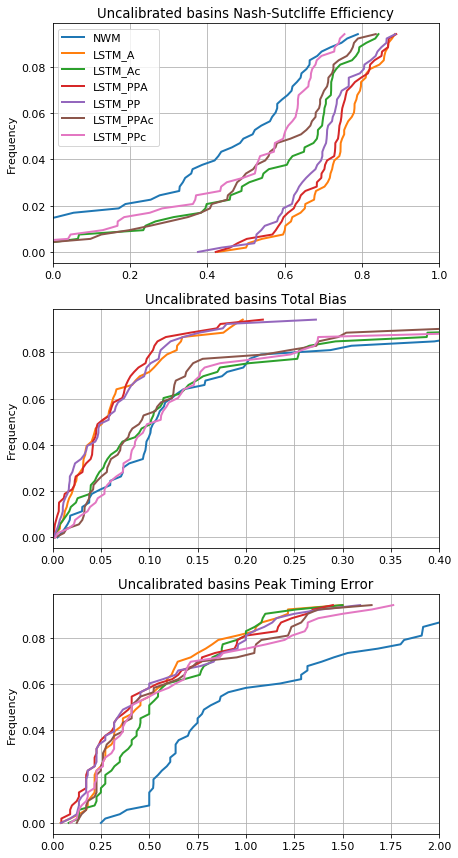

In [77]:
##### UNCALIBRATED BASINS
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,1, figsize=(6.5,3*4.02))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary_uncal[SMN][:,nmet]) for SMN in nwm_lstm_version_list]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
#    for imod,X in enumerate(x):
    for imod in plot_these_curves:
        plotdata = x[imod]
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        label_name = nwm_lstm_version_list[imod]
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=label_name, lw=2)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title('Uncalibrated basins ' + metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        
axes[0].legend()
fig.tight_layout() 

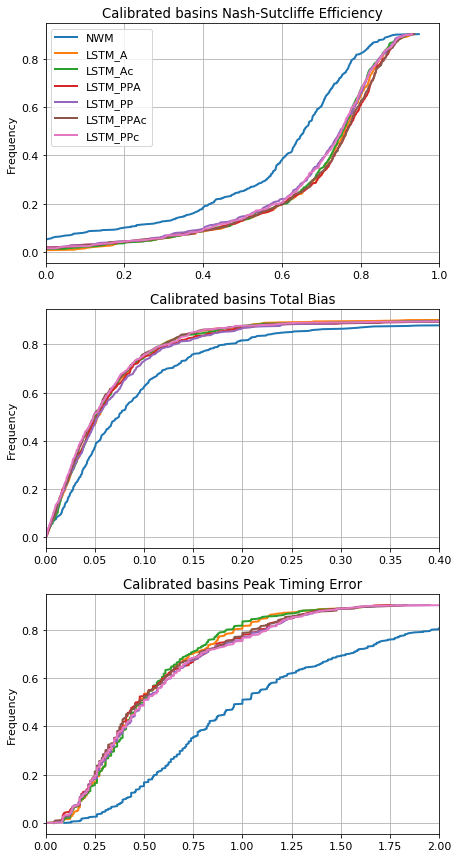

In [78]:
##### CALIBRATED BASINS
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
place_text = [[[0,.9], [.6,.0]], [[-.2,.2],[.1,.3]], [[0,1.7], [0,1.6]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,1, figsize=(6.5,3*4.02))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary_cal[SMN][:,nmet]) for SMN in nwm_lstm_version_list]
    # Just use absolute values for the bias, since negative values are hard to interpret
    if nmet==6:
        x = list(np.abs(x))
#    for imod,X in enumerate(x):
    for imod in plot_these_curves:
        plotdata = x[imod]
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        label_name = nwm_lstm_version_list[imod]
        axes[imet].plot(plotdata,  yvalues[:len(plotdata)], label=label_name, lw=2)
        axes[imet].grid()
        axes[imet].set_xlim(list(met_lims[nmet]))
        axes[imet].set_title('Calibrated basins ' + metric_names[imet])
        axes[imet].set_ylabel('Frequency')
        
axes[0].legend()
fig.tight_layout() 

# Regional analysis

In [159]:
unique_hydro_unit = attributes.basin_hydro_unit.unique()
nregions = len(unique_hydro_unit)

In [160]:
unique_hydro_unit

array(['01', '02', '03', '05', '06', '04', '09', '07', '10', '11', '08',
       '12', '13', '14', '15', '16', '18', '17'], dtype=object)

In [161]:
def calc_wilcoxon_huc(huc, huc_stat, M_base, M_test, absolute_values=False):
    if absolute_values:
        _, p = st.wilcoxon(np.abs(huc_stat[M_base][huc]), np.abs(huc_stat[M_test][huc]))
    else:
        _, p = st.wilcoxon(huc_stat[M_base][huc], huc_stat[M_test][huc])
    return p

In [162]:
# Need an array with huc,metric,basin,model
mod_types = ['NWM', 'LSTM_PPA', 'LSTM_PP', 'LSTM_A']

huc_stat_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=mod_types) for m in metric_names}


for test_model in ['LSTM_PPA','LSTM_PP']:

    print('Significance values for', test_model)

    huc_sig_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=['NWM', 'LSTM_A', 'n']) for m in metric_names}

    for imet, nmet in enumerate([0,6,11]):

        huc_stat = {model:{huc:[] for huc in unique_hydro_unit} for model in mod_types}

        for ihuc, huc in enumerate(unique_hydro_unit):
            for ib, b in enumerate(basin_list):
                if attributes.loc[int(b), 'basin_hydro_unit'] == huc:
                    for imod, mod_name in enumerate(mod_types):
                        huc_stat[mod_name][huc].append(ensemble_metric_dictionary[mod_name][ib,nmet])
            for imod, mod_name in enumerate(mod_types):
                huc_stat_dict[metric_names[imet]].loc[huc,mod_name] = np.mean(huc_stat[mod_name][huc])

        for ihuc, huc in enumerate(unique_hydro_unit):
            p = calc_wilcoxon_huc(huc, huc_stat, 'NWM', test_model)
            huc_sig_dict[metric_names[imet]].loc[huc,'NWM'] = p
            p = calc_wilcoxon_huc(huc, huc_stat, 'LSTM_A', test_model)
            huc_sig_dict[metric_names[imet]].loc[huc,'LSTM_A'] = p
            huc_sig_dict[metric_names[imet]].loc[huc,'n'] = len(huc_stat[mod_name][huc])
 
    for m in metric_names:
        huc_sig_dict[m] = huc_sig_dict[m].sort_index()
    print(huc_sig_dict)

for m in metric_names:
    huc_stat_dict[m] = huc_stat_dict[m].sort_index()
print(huc_stat_dict)

Significance values for LSTM_PPA


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


{'Nash-Sutcliffe Efficiency':        NWM  LSTM_A   n
01 0.00005 0.35482  22
02 0.00000 0.00000  69
03 0.00000 0.88344  79
04 0.00001 0.06564  30
05 0.00000 0.06659  35
06 0.00078 0.56949  16
07 0.00000 0.28446  29
08 0.06298 0.23672   7
09 0.65472 0.65472   2
10 0.00000 0.50194  49
11 0.00018 0.98705  22
12 0.01669 0.50084  32
13 0.01796 0.73532   7
14 0.00760 0.06914  15
15 0.02584 0.36269  14
16 0.04311 0.22492   5
17 0.00000 0.23197  72
18 0.00012 0.51721  26, 'Total Bias':        NWM  LSTM_A   n
01 0.00004 0.09453  22
02 0.00021 0.46391  69
03 0.10894 0.17897  79
04 0.11561 0.58571  30
05 0.00000 0.24486  35
06 0.50145 0.46911  16
07 0.08962 0.13856  29
08 0.17630 0.17630   7
09 0.17971 0.17971   2
10 0.39505 0.18093  49
11 0.80762 0.11535  22
12 0.57482 0.00670  32
13 0.86577 1.00000   7
14 0.49552 1.00000  15
15 0.04799 0.50980  14
16 0.89274 0.89274   5
17 0.00032 0.00000  72
18 0.15129 0.04903  26, 'Peak Timing Error':        NWM  LSTM_A   n
01 0.00007 0.88125  22
02 0.00000 0.

In [163]:
huc_stat_dict

{'Nash-Sutcliffe Efficiency':         NWM LSTM_PPA LSTM_PP  LSTM_A
 01  0.61898  0.78209 0.76723 0.77875
 02  0.53268  0.73307 0.71547 0.70188
 03  0.54635  0.70336 0.68697 0.70484
 04  0.41554  0.68614 0.65650 0.71356
 05  0.65135  0.75206 0.72578 0.74069
 06  0.69453  0.78987 0.77625 0.78792
 07  0.45902  0.71267 0.67901 0.70489
 08  0.59327  0.66261 0.63476 0.68280
 09  0.28810  0.39691 0.44141 0.28406
 10 -0.08448  0.44472 0.42465 0.57481
 11  0.33387  0.58511 0.55812 0.63625
 12  0.28706  0.32039 0.31802 0.34061
 13  0.31229  0.65775 0.66589 0.64544
 14  0.51203  0.74597 0.74953 0.80388
 15 -0.01959  0.38677 0.38896 0.48937
 16  0.20804  0.70136 0.69344 0.72266
 17  0.67486  0.80644 0.79399 0.81435
 18  0.59421  0.73749 0.69782 0.75016,
 'Total Bias':         NWM LSTM_PPA  LSTM_PP   LSTM_A
 01 -0.05095  0.06021  0.07498  0.07215
 02  0.01391  0.02732  0.03563  0.02963
 03  0.00593 -0.01581 -0.00730 -0.00874
 04  0.01743  0.05117  0.05580  0.05455
 05 -0.04239  0.03008  0.03594  0.

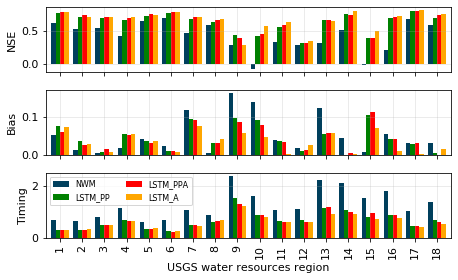

In [192]:
plot_models = ['NWM', 'LSTM_PP', 'LSTM_PPA', 'LSTM_A']
colorz={'NWM':'#ffa600', 'LSTM_PPA':'green', 'LSTM_PP':'red', 'LSTM_A':'#003f5c'}
colorz=['#003f5c', 'green', 'red','#ffa600']
fig_scale=1
mpl.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(3, sharex=False, figsize=(fig_scale*6.5, fig_scale*4.02))
for imet, nmet in enumerate([0,6,11]):
    m = metric_names[imet]
    df_plot = pd.DataFrame(data=np.transpose(np.array([huc_stat_dict[m][imod] for imod in plot_models])), 
                           index=range(1, 19), columns=plot_models)
    if imet == 1:
        df_plot = df_plot.abs() 
    if imet < 2:
        df_plot.plot.bar(ax=axs[imet], width=.8, legend=None, color=colorz)
        axs[imet].set_xticklabels([])
    else:
        df_plot.plot.bar(ax=axs[imet], width=.8, color=colorz)
        axs[imet].set_xlabel('USGS water resources region')
        axs[imet].legend(loc='upper left', prop={'size': 8}, ncol=2)
    axs[imet].set_ylabel(short_metric_names[imet])
    axs[imet].grid(alpha=0.3)

plt.tight_layout()
plt.show()
fig.savefig('fig6.png', dpi=1200)
plt.close()

In [193]:
for imet, nmet in enumerate([0,6,11]):
    m = metric_names[imet]
    df_plot = pd.DataFrame(data=np.transpose(np.array([huc_stat_dict[m][imod] for imod in plot_models])), 
                           index=range(1, 19), columns=plot_models)
    if imet == 1:
        df_plot = df_plot.abs() 
    print(m)
    print('LSTM_PPA', st.stats.pearsonr(df_plot['NWM'], df_plot['LSTM_PPA'])[0])
    print('LSTM_PP', st.stats.pearsonr(df_plot['NWM'], df_plot['LSTM_PP'])[0])
    print('LSTM_A', st.stats.pearsonr(df_plot['NWM'], df_plot['LSTM_A'])[0])
    print('PPA vs LSTM_A', st.stats.pearsonr(df_plot['LSTM_PPA'], df_plot['LSTM_A'])[0])
    print('PP vs LSTM_A', st.stats.pearsonr(df_plot['LSTM_PP'], df_plot['LSTM_A'])[0])

Nash-Sutcliffe Efficiency
LSTM_PPA 0.7870719489016936
LSTM_PP 0.7875394009355488
LSTM_A 0.6235769090725294
PPA vs LSTM_A 0.9414409518356114
PP vs LSTM_A 0.9130541417497458
Total Bias
LSTM_PPA 0.5512177826465654
LSTM_PP 0.5940215958690992
LSTM_A 0.42481295715142653
PPA vs LSTM_A 0.8192514991553064
PP vs LSTM_A 0.839859102464303
Peak Timing Error
LSTM_PPA 0.9567916130278362
LSTM_PP 0.9592842759738236
LSTM_A 0.9219320846579325
PPA vs LSTM_A 0.9777223323277888
PP vs LSTM_A 0.9833641343425849


In [86]:
huc_stat_dict

{'Nash-Sutcliffe Efficiency':         NWM LSTM_PPA LSTM_PP  LSTM_A
 01  0.61898  0.78209 0.76723 0.77875
 02  0.53268  0.73307 0.71547 0.70188
 03  0.54635  0.70336 0.68697 0.70484
 04  0.41554  0.68614 0.65650 0.71356
 05  0.65135  0.75206 0.72578 0.74069
 06  0.69453  0.78987 0.77625 0.78792
 07  0.45902  0.71267 0.67901 0.70489
 08  0.59327  0.66261 0.63476 0.68280
 09  0.28810  0.39691 0.44141 0.28406
 10 -0.08448  0.44472 0.42465 0.57481
 11  0.33387  0.58511 0.55812 0.63625
 12  0.28706  0.32039 0.31802 0.34061
 13  0.31229  0.65775 0.66589 0.64544
 14  0.51203  0.74597 0.74953 0.80388
 15 -0.01959  0.38677 0.38896 0.48937
 16  0.20804  0.70136 0.69344 0.72266
 17  0.67486  0.80644 0.79399 0.81435
 18  0.59421  0.73749 0.69782 0.75016,
 'Total Bias':         NWM LSTM_PPA  LSTM_PP   LSTM_A
 01 -0.05095  0.06021  0.07498  0.07215
 02  0.01391  0.02732  0.03563  0.02963
 03  0.00593 -0.01581 -0.00730 -0.00874
 04  0.01743  0.05117  0.05580  0.05455
 05 -0.04239  0.03008  0.03594  0.

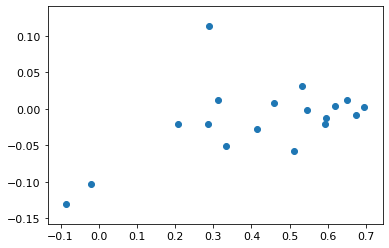

In [87]:
diffss = (huc_stat_dict['Nash-Sutcliffe Efficiency']['LSTM_PPA'].values - 
          huc_stat_dict['Nash-Sutcliffe Efficiency']['LSTM_A'].values)
plt.scatter(huc_stat_dict['Nash-Sutcliffe Efficiency']['NWM'].values, diffss)

NSE


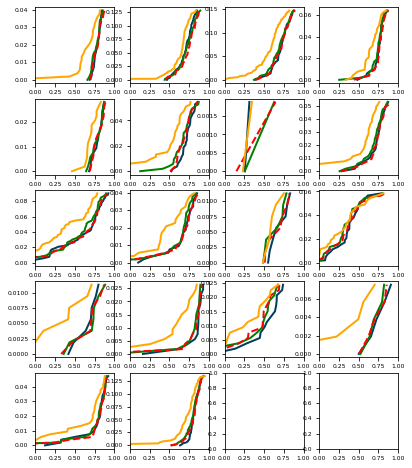

Beta-NSE


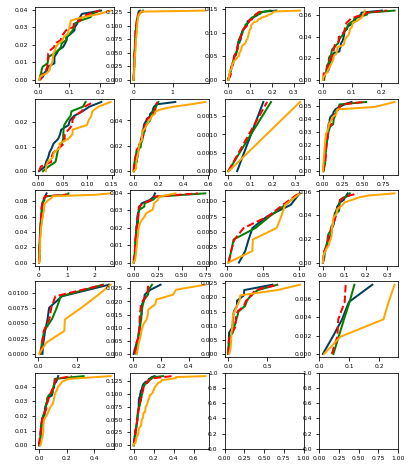

Peak-Timing


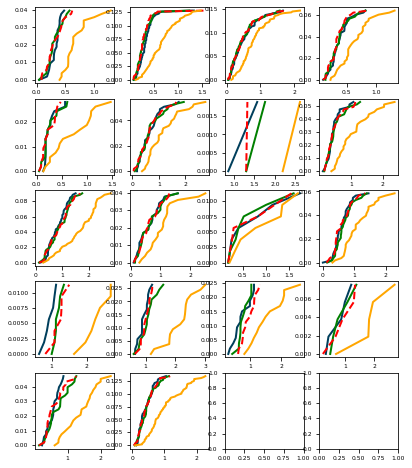

In [88]:
met_xlims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [0,.4],[-50,50], [],[],[],[0,2]]
met_ylims = [[0,1],  [],      [],      [],     [],    [],    [0,1], [],       [],[],[],[0,1]]
mpl.rcParams.update({'font.size': 6})
# Need an array with huc,metric,basin,model
mod_types = ['LSTM_A', 'LSTM_PP', 'LSTM_PPA', 'NWM']

huc_stat_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=mod_types) for m in metric_names}

for imet, nmet in enumerate([0,6,11]):
    
    print(use_metrics[imet])
    
    fig, axes = plt.subplots(5,4, figsize=(6.5,8.125))
    
    huc_stat = {model:{huc:[] for huc in unique_hydro_unit} for model in mod_types}

    pltrow=0
    pltcol=0
    for ihuc, huc in enumerate(unique_hydro_unit):
        for ib, b in enumerate(basin_list):
            if attributes.loc[int(b), 'basin_hydro_unit'] == huc:
                for imod, mod_name in enumerate(mod_types):
                    huc_stat[mod_name][huc].append(ensemble_metric_dictionary[mod_name][ib,nmet])
        
        for imod, mod_name in enumerate(mod_types):
            plotdata = np.array(huc_stat[mod_name][huc])
            if nmet==6:
                for idata in range(plotdata.shape[0]):
                    plotdata[idata] = np.abs(plotdata[idata])
            plotdata = np.sort(plotdata[~pd.isnull(plotdata)])

            axes[pltrow,pltcol].plot(plotdata,  yvalues[:len(plotdata)], 
                            label=labelz[imod],
                            color=colorz[imod], 
                            linestyle=linestylz[imod],
                            linewidth=2)
            axes[pltrow,pltcol].plot
            axes[pltrow,pltcol].grid(False)
            if nmet == 0:
                axes[pltrow,pltcol].set_xlim(list(met_xlims[nmet]))
            # Turn off tick labels
#             axes[pltrow,pltcol].set_yticklabels([])
#             axes[pltrow,pltcol].set_xticklabels([])
#             axes[pltrow,pltcol].tick_params(
#                 axis='x',          # changes apply to the x-axis
#                 which='both',      # both major and minor ticks are affected
#                 bottom=False,      # ticks along the bottom edge are off
#                 top=False,         # ticks along the top edge are off
#                 labelbottom=False) # labels along the bottom edge are off
#             axes[pltrow,pltcol].tick_params(
#                 axis='y',          # changes apply to the x-axis
#                 which='both',      # both major and minor ticks are affected
#                 bottom=False,      # ticks along the bottom edge are off
#                 top=False,         # ticks along the top edge are off
#                 labelbottom=False) # labels along the bottom edge are off

        if pltcol<3:
            pltcol +=1
        else:
            pltrow+=1
            pltcol=0
    plt.show()
    plt.close()

01466500


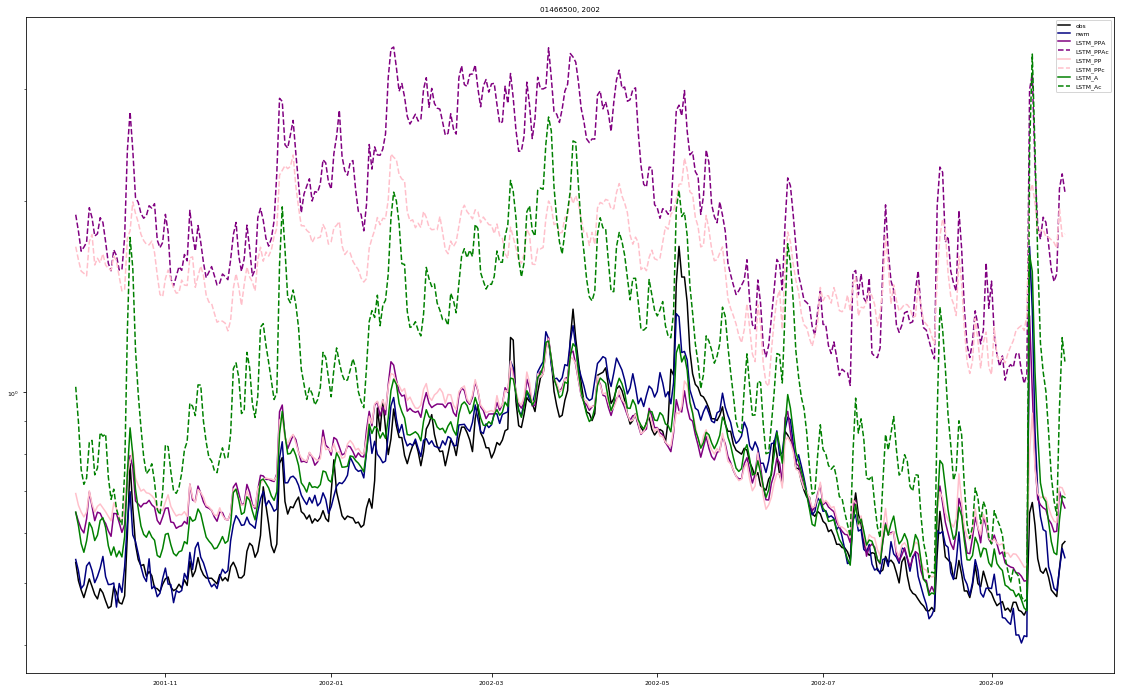

01484100


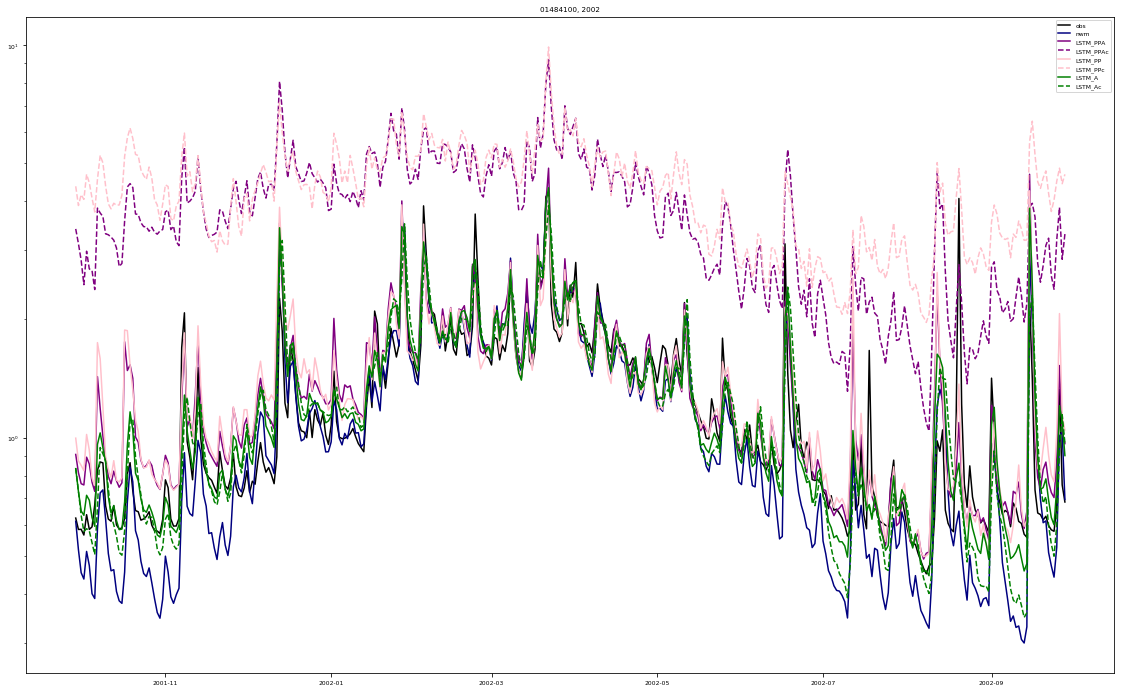

In [89]:
plot_models = ['LSTM_PPA','LSTM_PPAc', 'LSTM_PP','LSTM_PPc', 'LSTM_A','LSTM_Ac']
fig_scale=3
colorz=['k','navy','purple','purple','pink','pink','green','green']
linestylez=['-','-','-','--','-','--','-','--']

#for b in list(lstm_sample.keys()):
for b in ['01466500', '01484100']:
    print(b)
    plot_start = 0
    plot_end = 365
    model_year_averages={imodel:np.zeros(365) for imodel in plot_models}
    nwm_year_averages=np.zeros(365)
    obs_year_averages=np.zeros(365)
    fig, ax = plt.subplots(figsize=(fig_scale*6.5,fig_scale*4.02))
    for iyear in range(7):
        plot_start = plot_start+365
        plot_end = plot_end+365
        xtime=lstm_sample[b].iloc[plot_start:plot_end, 0].index
        for t in range(365):
            for imodel in plot_models:
                model_year_averages[imodel][t] += ensemble_q_dictionary[imodel][b].iloc[plot_start+t]
            obs_year_averages[t] += lstm_sample[b].iloc[plot_start+t, 0]
            nwm_year_averages[t] += lstm_sample[b].iloc[plot_start+t, 1]
    ax.plot(xtime,obs_year_averages/7, label='obs',c=colorz[0],linestyle=linestylez[0])
    ax.plot(xtime,nwm_year_averages/7, label='nwm',c=colorz[1],linestyle=linestylez[1])
    for istyle, imodel in enumerate(plot_models):
        ax.plot(xtime,model_year_averages[imodel]/7, label=imodel,
                c=colorz[istyle+2], linestyle=linestylez[istyle+2])
    ax.legend()
    ax.set_yscale('log')
    ax.set_title(b+', '+str(iyear+1996))
    plt.show()
    plt.close()

01466500


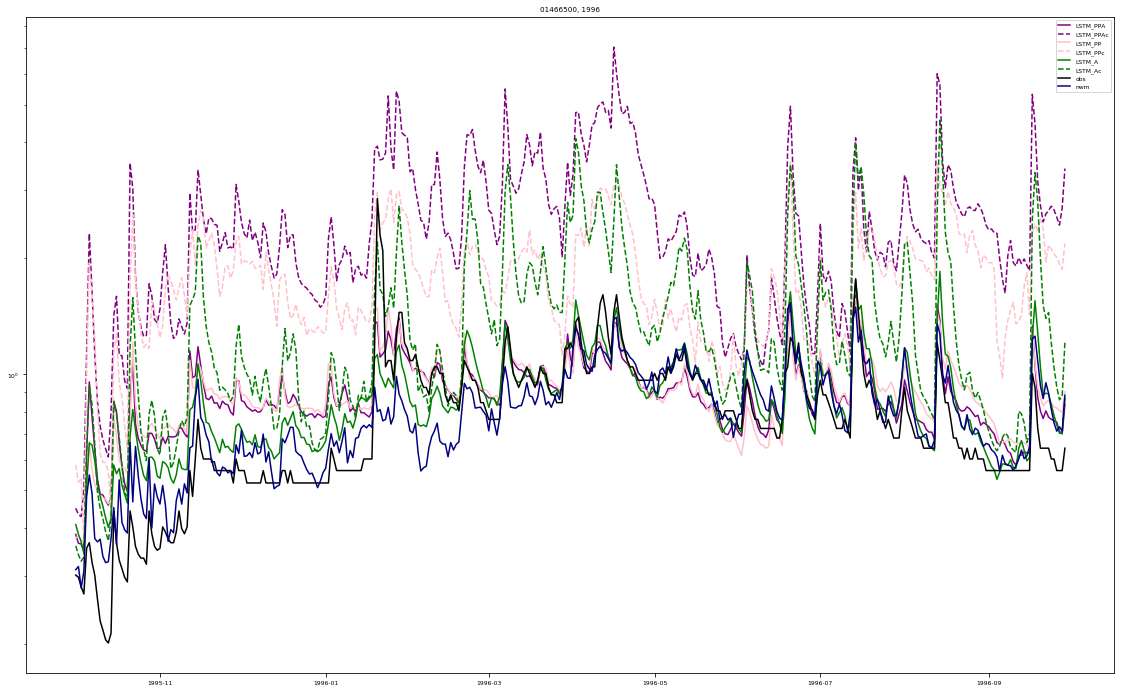

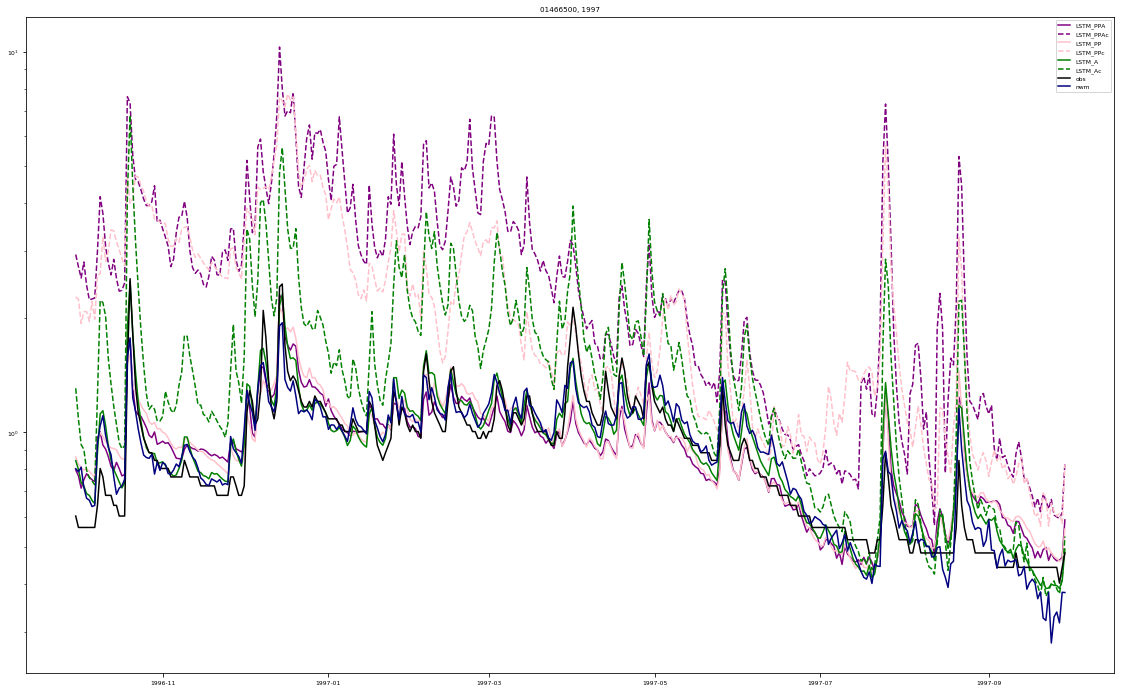

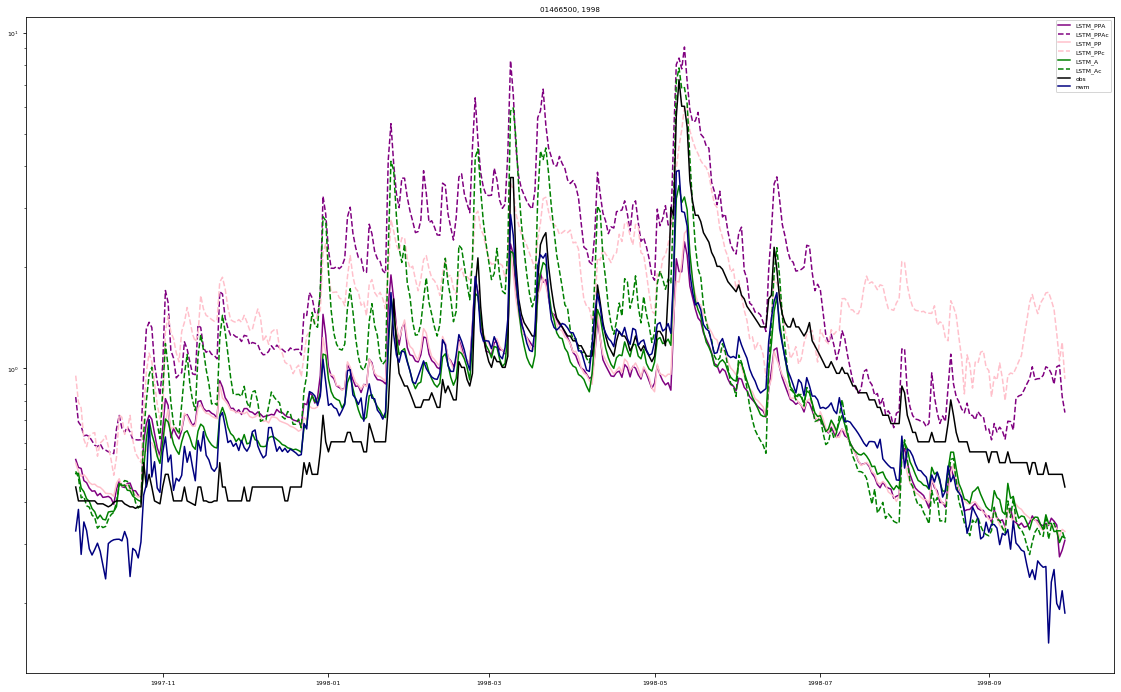

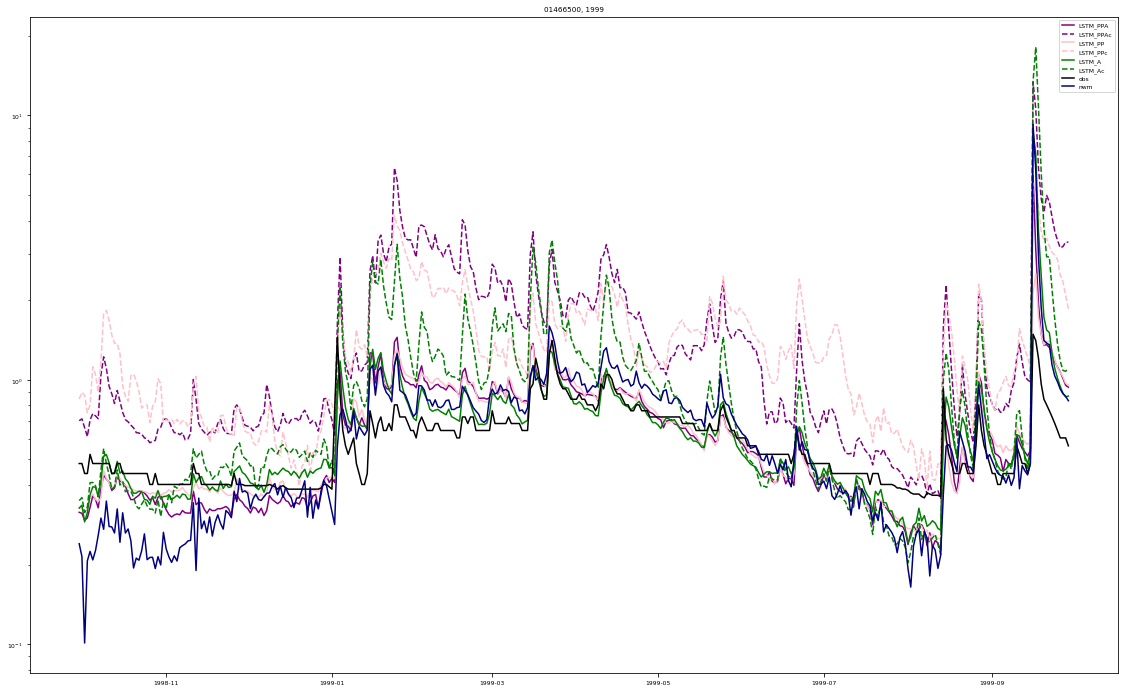

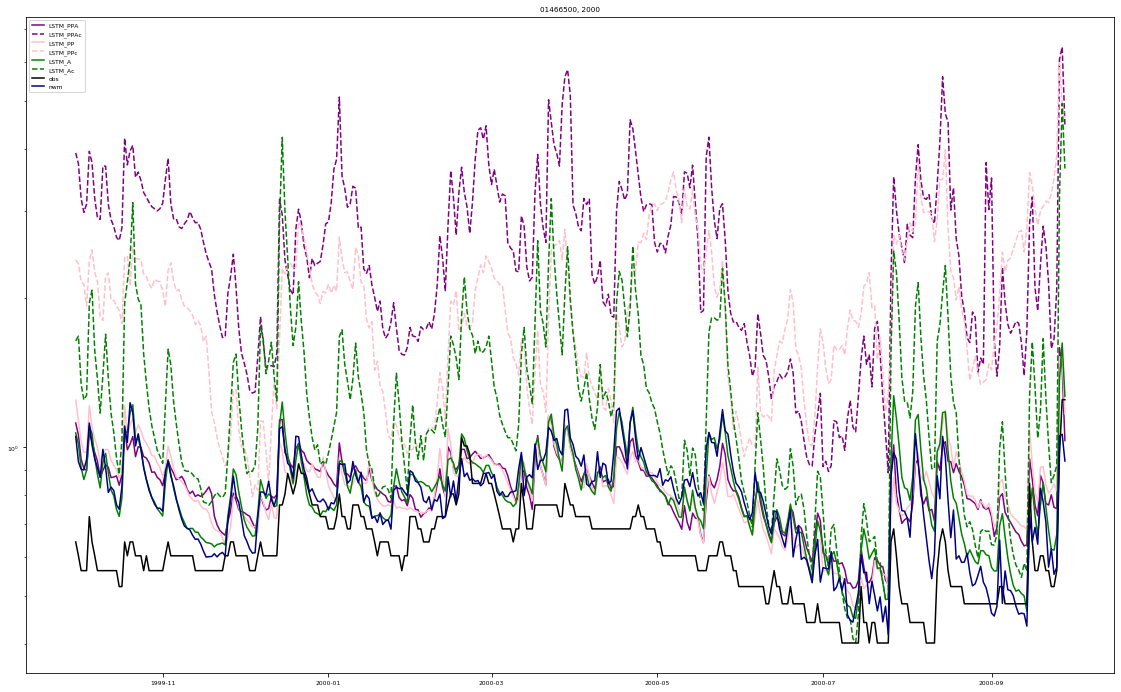

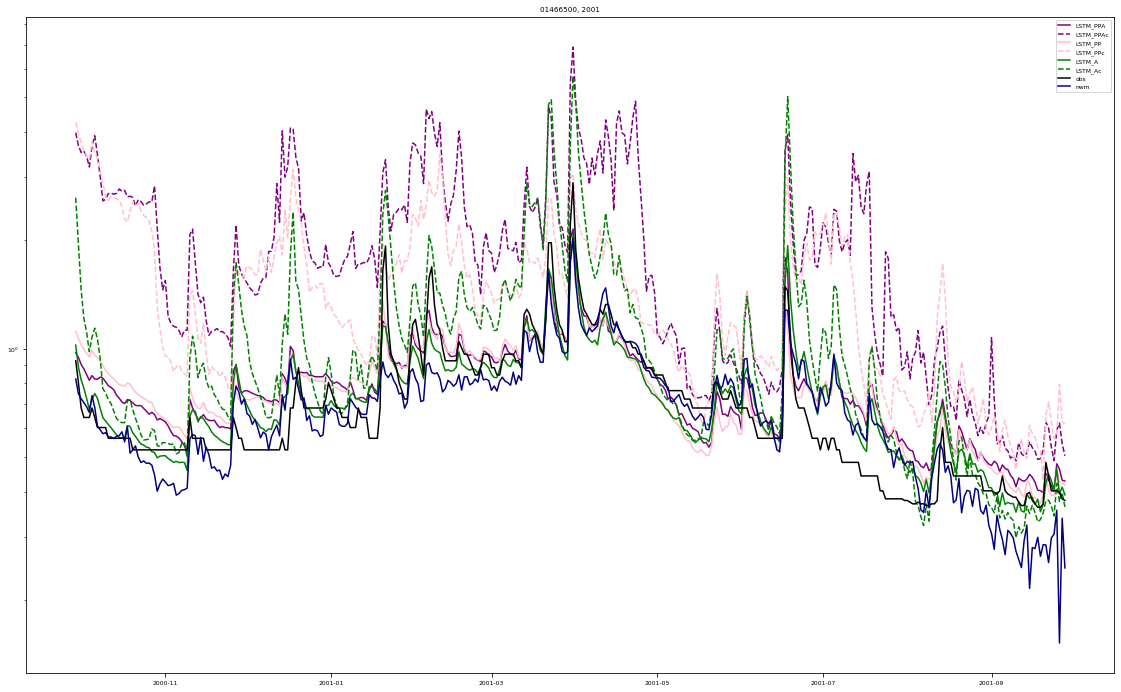

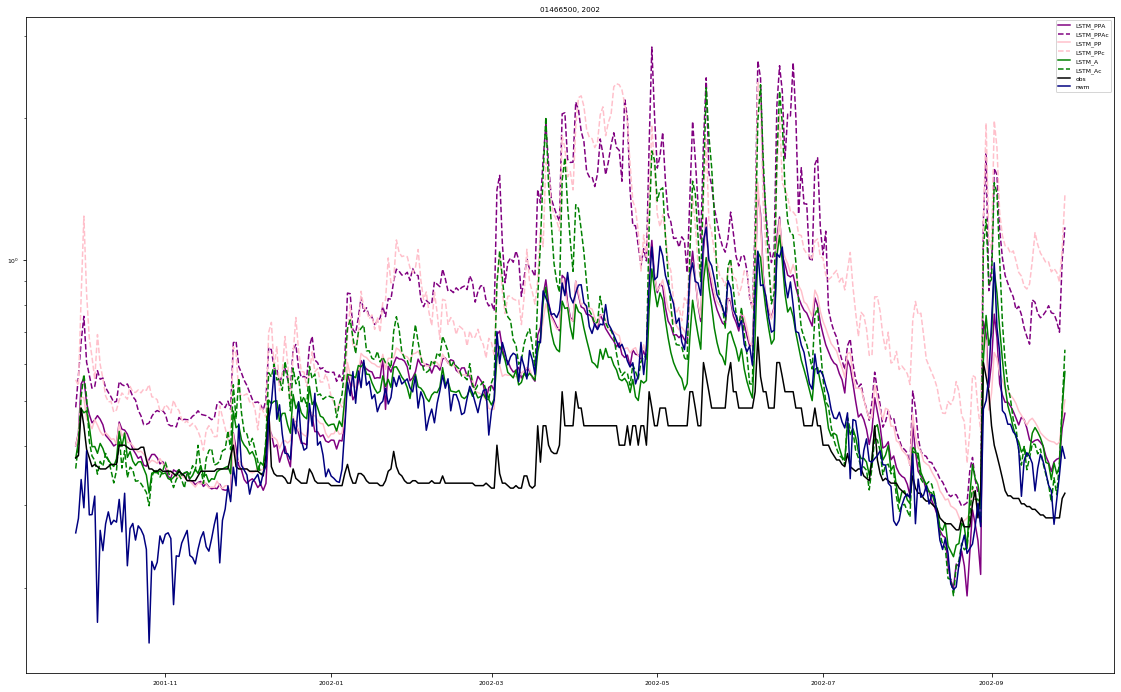

01484100


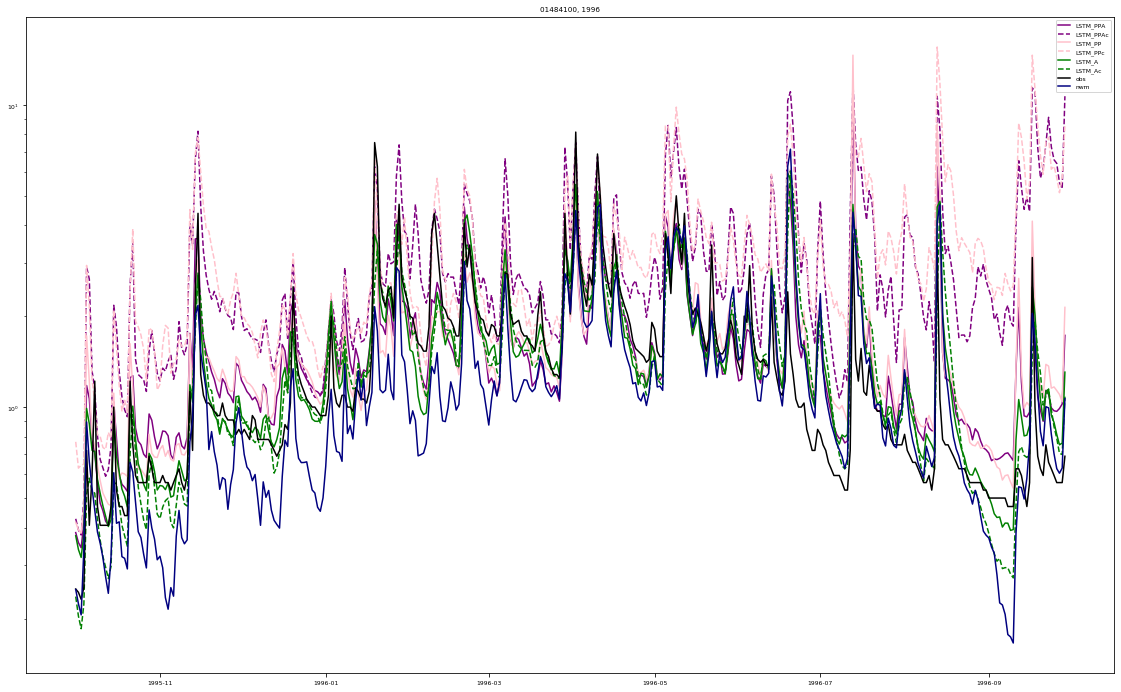

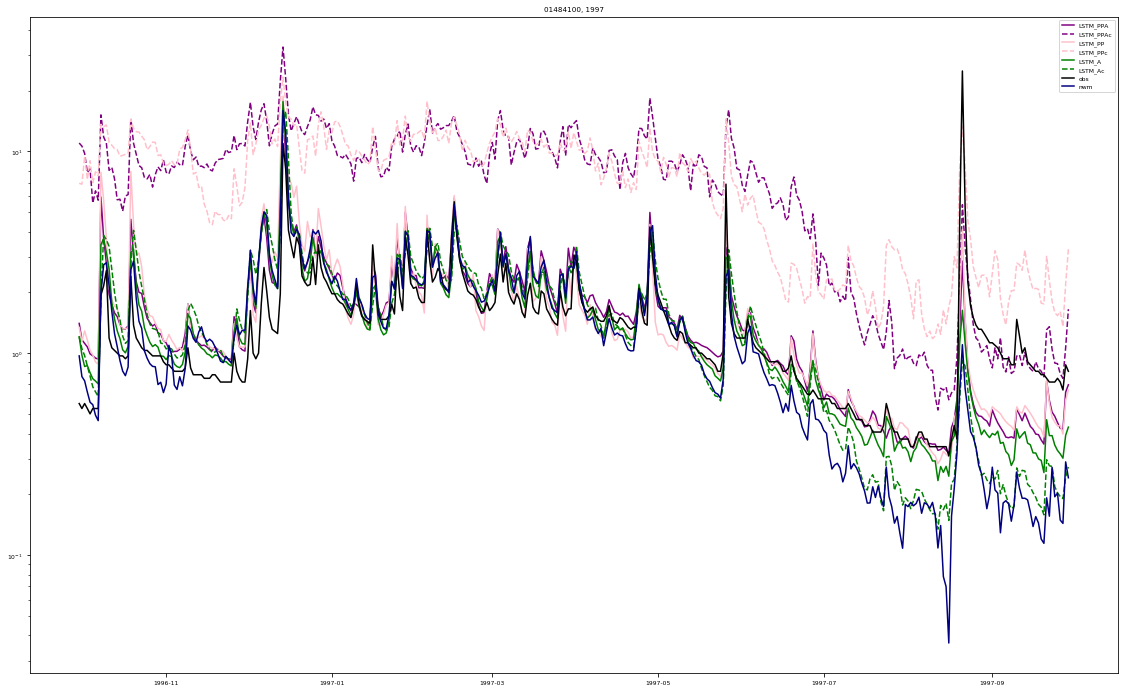

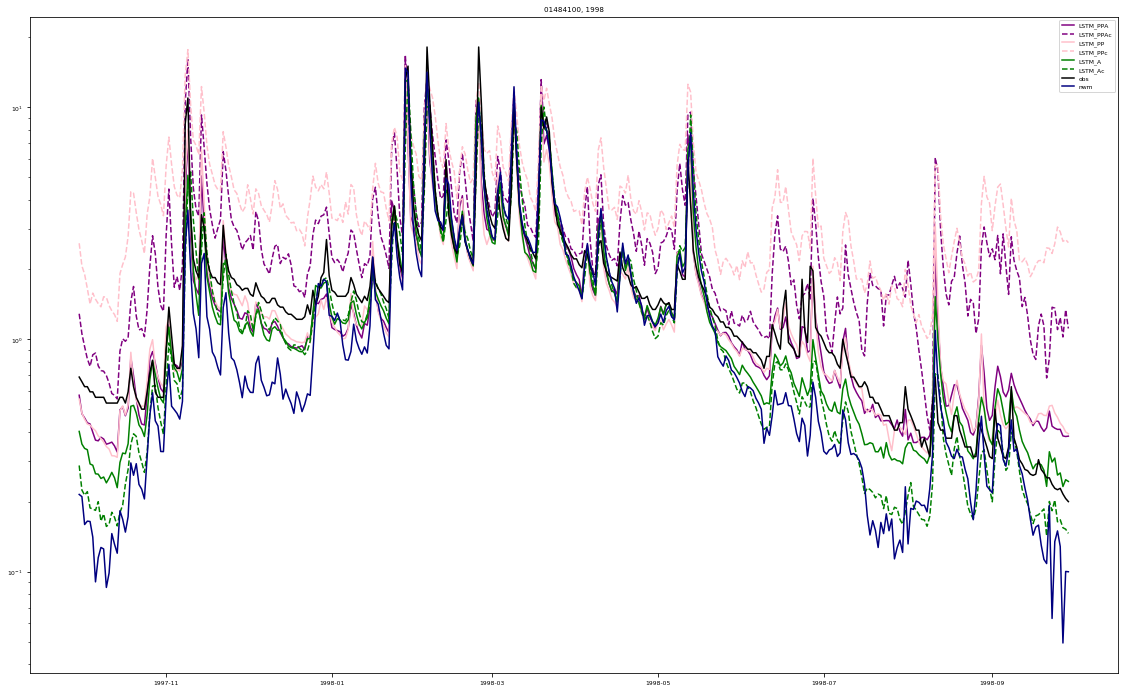

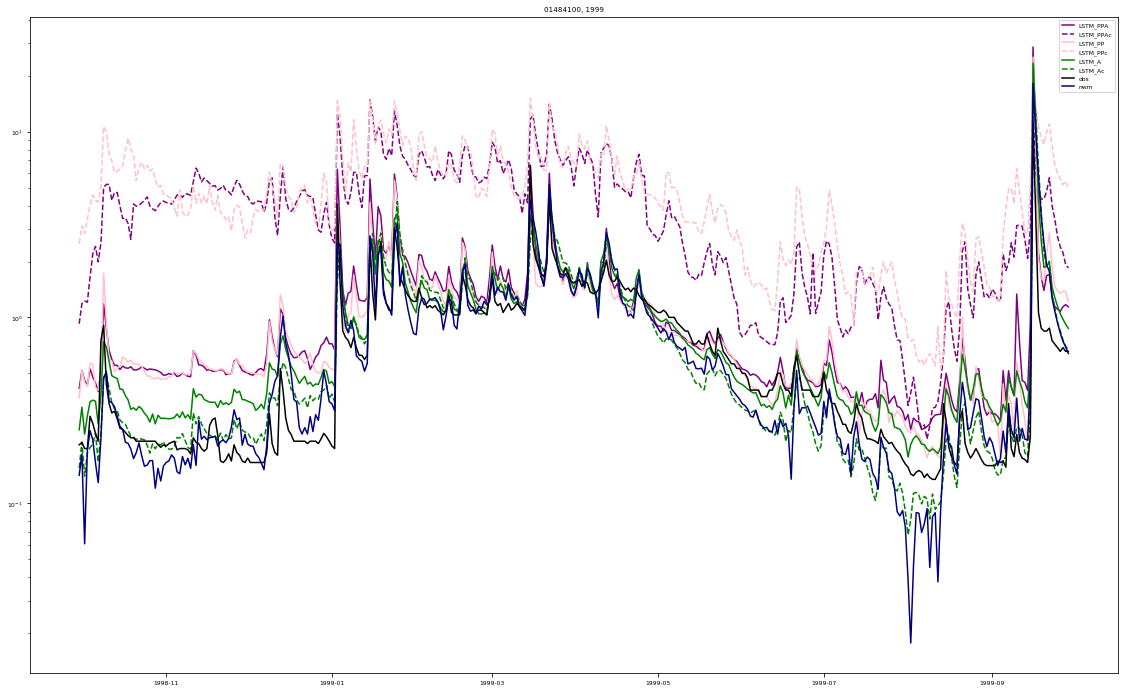

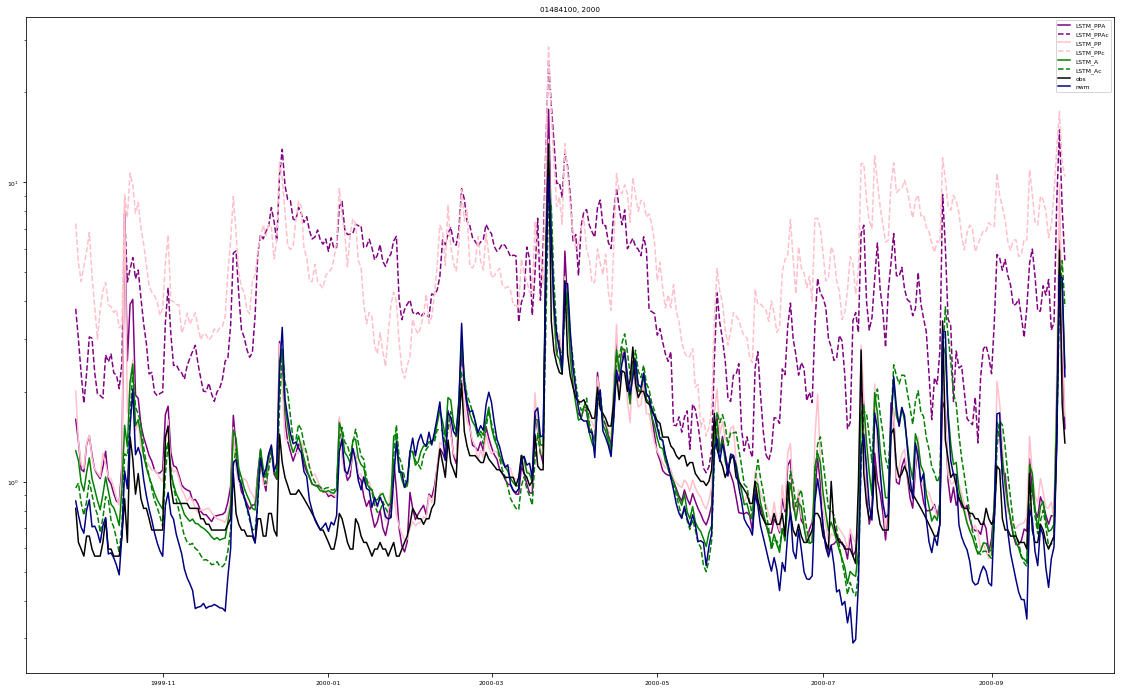

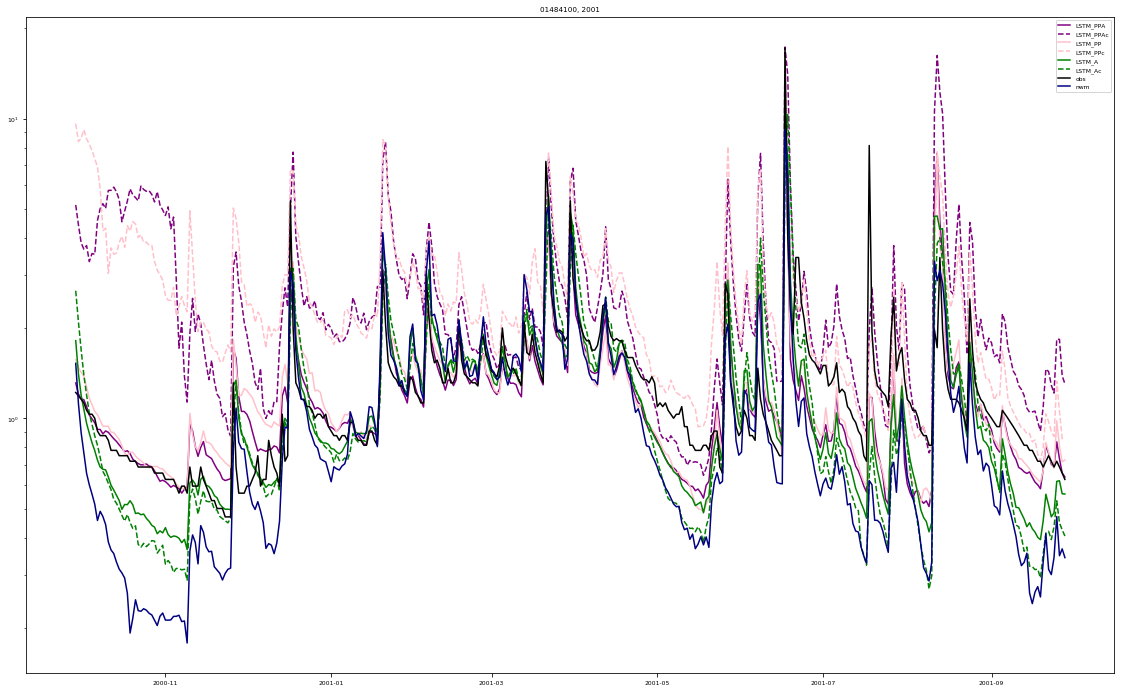

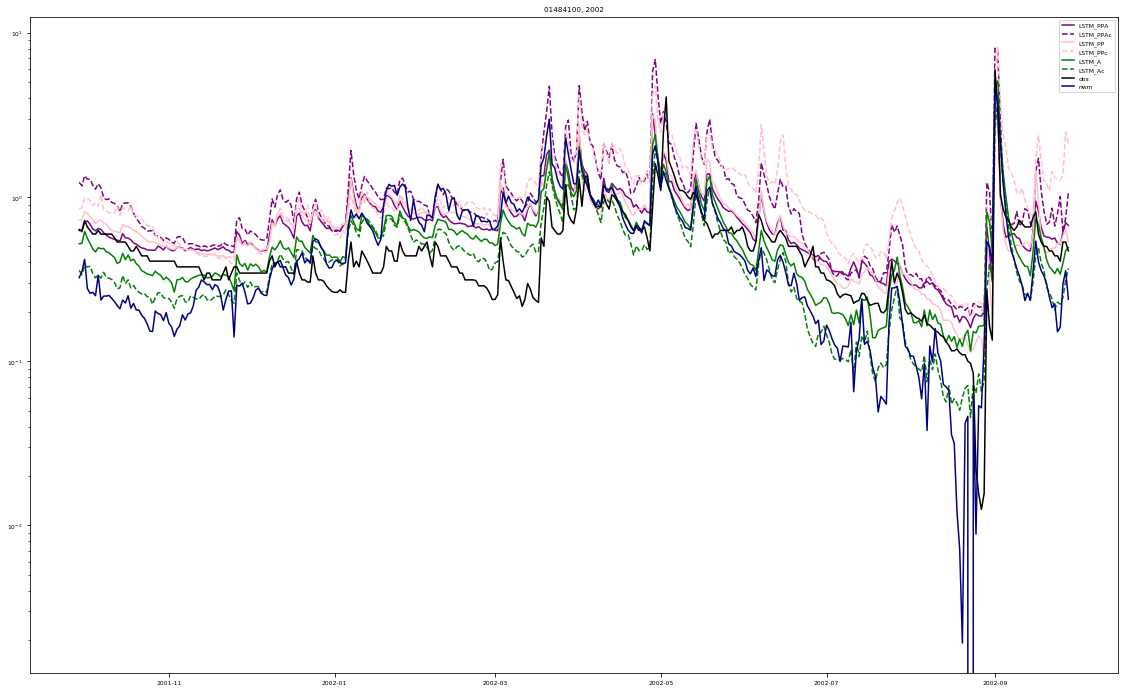

In [90]:
plot_models = ['LSTM_PPA','LSTM_PPAc', 'LSTM_PP','LSTM_PPc', 'LSTM_A','LSTM_Ac']
fig_scale=3
colorz=['k','navy','purple','purple','pink','pink','green','green']
linestylez=['-','-','-','--','-','--','-','--']

for b in ['01466500', '01484100']:
    print(b)
    plot_start = 0
    plot_end = 365
    model_year_averages={imodel:np.zeros(365) for imodel in plot_models}
    nwm_year_averages=np.zeros(365)
    obs_year_averages=np.zeros(365)

    for iyear in range(7):
        plot_start = plot_start+365
        plot_end = plot_end+365
        fig, ax = plt.subplots(figsize=(fig_scale*6.5,fig_scale*4.02))
        xtime=lstm_sample[b].iloc[plot_start:plot_end, 0].index
        for istyle, imodel in enumerate(plot_models):
                #model_year_averages[imodel][t] += ensemble_q_dictionary[imodel][b].iloc[plot_start:plot_end]
            ax.plot(ensemble_q_dictionary[imodel][b].iloc[plot_start:plot_end], label=imodel,
                    c=colorz[istyle+2], linestyle=linestylez[istyle+2])
        ax.plot(lstm_sample[b].iloc[plot_start:plot_end, 0], label='obs',c=colorz[0],linestyle=linestylez[0])
        ax.plot(lstm_sample[b].iloc[plot_start:plot_end, 1], label='nwm',c=colorz[1],linestyle=linestylez[1])

        ax.legend()
        ax.set_yscale('log')
        ax.set_title(b+', '+str(iyear+1996))
        plt.show()
        plt.close()

In [91]:
min_calibrated_area = 10000
for index, row in attributes.iterrows():
    if row['calibrated'] is True:
        if row['area_gages2'] < min_calibrated_area:
            min_calibrated_area = row['area_gages2']
            print('minimum basin area set for {} at {}'.format(row['area_gages2'], row['basin_id_str']))
#attributes['area_geospa_fabric']

minimum basin area set for 769.05 at 01031500
minimum basin area set for 383.82 at 01052500
minimum basin area set for 180.98 at 01054200
minimum basin area set for 31.3 at 01073000
minimum basin area set for 30.54 at 02055100
minimum basin area set for 29.72 at 03368000
minimum basin area set for 22.46 at 10259000
minimum basin area set for 19.6 at 10336645


In [92]:
row

q_mean                    7.56810
runoff_ratio              1.36213
slope_fdc                 2.01743
baseflow_index            0.48578
stream_elas               1.38623
q5                        0.25071
q95                      31.22680
high_q_freq              26.45000
high_q_dur                3.52667
low_q_freq              148.45000
low_q_dur                46.39062
hfd_mean                123.90000
geol_1st_class                  1
glim_1st_class_frac       0.60624
carbonate_rocks_frac      0.00000
geol_porostiy             0.12160
geol_permeability       -14.71630
p_mean                    5.55607
pet_mean                  2.27967
p_seasonality            -1.01595
frac_snow                 0.02433
aridity                   0.41030
high_prec_freq           19.30000
high_prec_dur             1.53785
low_prec_freq           237.00000
low_prec_dur              6.90962
low_prec_timing                 3
gauge_lat                42.12344
gauge_lon              -124.18731
elev_mean     